# 0. 라이브러리 호출

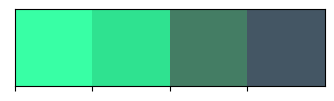

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew, kurtosis, norm, probplot

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV, KFold, cross_val_score
import optuna
from optuna.samplers import TPESampler

from sklearn import model_selection

sns.palplot(['#38FFA5','#2FE290','#447D64', '#445664'])
color=['#38FFA5','#2FE290','#447D64', '#445664']

**Feature Description**


| Feature       | Description     |
|:--------------|:----------------|
| id            | 고유 id          |
| hour          | 시간             |
| hour_bef_temperature   | 기온             |
| hour_bef_precipitation | 비가 오지 않았으면 0, 비가 오면 1 |
| hour_bef_windspeed     | 풍속(평균)        |
| hour_bef_humidity      | 습도             |
| hour_bef_visibility    | 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미) |
| hour_bef_ozone         | 오존             |
| hour_bef_pm10          | 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지) |
| hour_bef_pm2.5         | 초미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지) |
| count         | 시간에 따른 따릉이 대여 수 |


# 1. 데이터 전처리

## 1-1. 호출

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')
display(train.head())
display(test.head())
display(submission.head())

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


,id,count
0,0,NaN
1,1,NaN
2,2,NaN
3,4,NaN
4,5,NaN


## 1-2. 데이터 구조 평가

In [3]:
train['hour_bef_precipitation'].unique()

array([ 1.,  0., nan])

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [5]:
train.rename(lambda x: x.lower().strip().replace('hour_bef_', ''), axis = 'columns', inplace = True)
test.rename(lambda x: x.lower().strip().replace('hour_bef_', ''), axis = 'columns', inplace = True)

In [6]:
print(train.columns) ; print(test.columns)

Index(['id', 'hour', 'temperature', 'precipitation', 'windspeed', 'humidity',
       'visibility', 'ozone', 'pm10', 'pm2.5', 'count'],
      dtype='object')
Index(['id', 'hour', 'temperature', 'precipitation', 'windspeed', 'humidity',
       'visibility', 'ozone', 'pm10', 'pm2.5'],
      dtype='object')


In [7]:
train.describe()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


In [8]:
train.columns.to_series().groupby(train.dtypes).groups

{int64: ['id', 'hour'], float64: ['temperature', 'precipitation', 'windspeed', 'humidity', 'visibility', 'ozone', 'pm10', 'pm2.5', 'count']}

In [9]:
train.duplicated('id', keep = False).sum()

0

In [10]:
train.isnull().sum()

id                 0
hour               0
temperature        2
precipitation      2
windspeed          9
humidity           2
visibility         2
ozone             76
pm10              90
pm2.5            117
count              0
dtype: int64

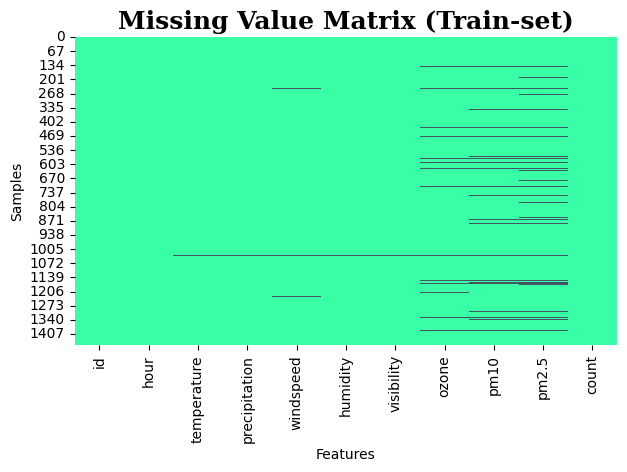

In [11]:
plt.figure(figsize = (7, 4))
sns.heatmap(train.isnull(), cbar=False, cmap = color)
plt.title("Missing Value Matrix (Train-set)", fontfamily = 'serif', fontweight = 'bold', fontsize = 18)
plt.xlabel("Features", fontsize = 10)
# plt.xticks(rotation = 0)
plt.ylabel("Samples", fontsize = 10)
plt.show()

In [12]:
train.groupby('hour').mean()

,id,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
hour,,,,,,,,,,
0,1200.016667,14.788136,0.016949,1.965517,58.169492,1434.220339,0.033763,55.881356,30.982759,71.766667
1,1074.918033,14.155738,0.049180,1.836667,60.459016,1400.852459,NaN,NaN,NaN,47.606557
2,1077.885246,13.747541,0.049180,1.633333,61.721311,1374.278689,0.030492,58.475410,31.366667,31.409836
3,1146.704918,13.357377,0.032787,1.620000,63.131148,1326.311475,0.031213,59.180328,31.466667,21.377049
4,1194.786885,13.001639,0.016393,1.409836,64.573770,1264.606557,0.031984,58.278689,32.116667,13.524590
5,1091.819672,12.673770,0.016393,1.296721,66.000000,1203.426230,0.031623,56.721311,31.525424,13.114754
6,1112.393443,12.377049,0.016393,1.331148,67.409836,1146.229508,0.029317,56.150000,31.603448,24.557377
7,1086.262295,12.191803,0.016393,1.262295,67.934426,1150.311475,0.025300,56.533333,31.779661,62.360656
8,1086.491803,12.600000,0.032787,1.632787,64.049180,1152.868852,0.021197,57.918033,31.796610,136.688525


In [13]:
train[train['ozone'].isnull()].groupby('hour').size()
# train[train['temperature'].isna()] 
# train[train['ozone'].isna()]

hour
0      1
1     61
6      1
7      1
10     1
11     1
12     1
13     1
15     1
16     3
17     2
18     2
dtype: int64

## 1-3. 누락 데이터 관리 및 검증

In [14]:
train.isnull().sum()

id                 0
hour               0
temperature        2
precipitation      2
windspeed          9
humidity           2
visibility         2
ozone             76
pm10              90
pm2.5            117
count              0
dtype: int64

In [15]:
train.isna().any()

id               False
hour             False
temperature       True
precipitation     True
windspeed         True
humidity          True
visibility        True
ozone             True
pm10              True
pm2.5             True
count            False
dtype: bool

### 시간대별 평균값으로 결측 대체

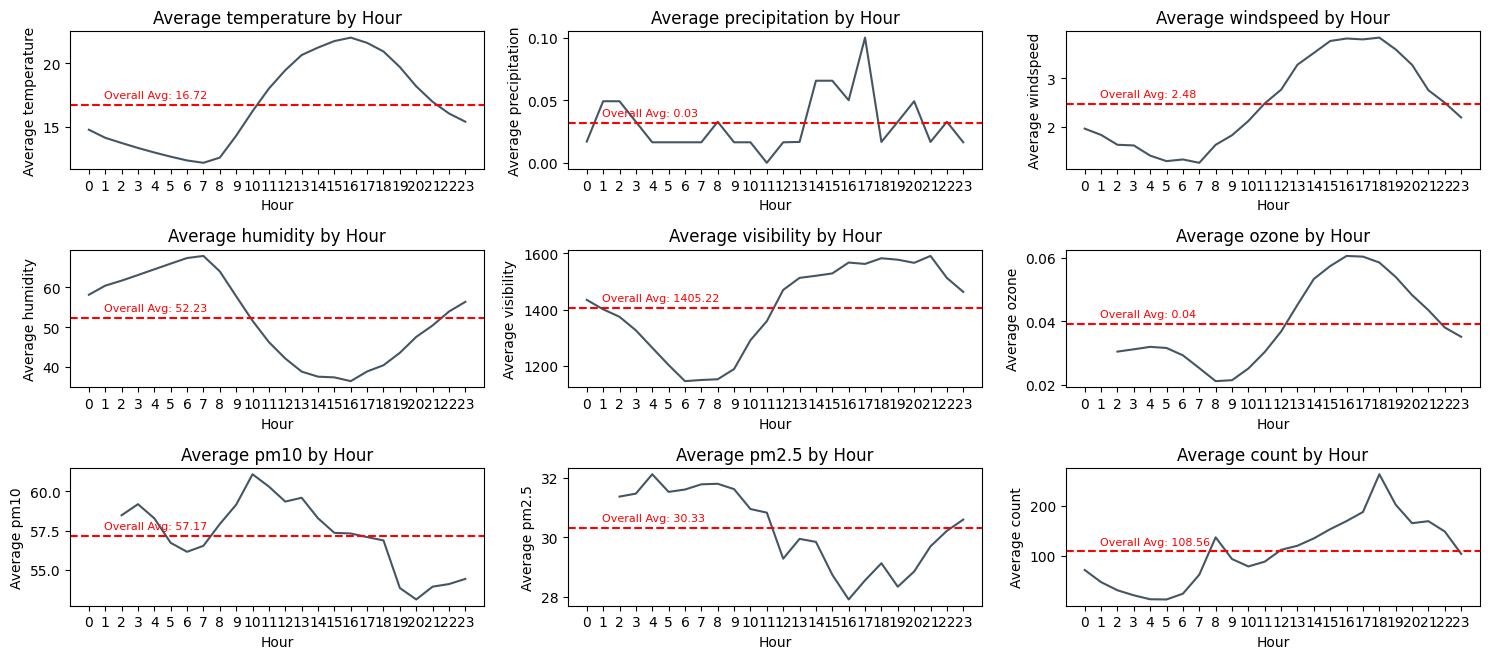

In [16]:
naCols =  ['temperature', 'precipitation', 'windspeed', 'humidity', 'visibility', 'ozone', 'pm10', 'pm2.5']

fig = plt.figure(figsize=(15, 15))

for i, col in enumerate(train.columns[2:]):
    ax = plt.subplot(7, 3, i+1)  
    series = train.groupby('hour')[col].mean()
    
    ax.plot(series.index, series.values, color = color[3]) 
    ax.set_title(f"Average {col} by Hour")
    ax.set_xlabel('Hour')
    ax.set_ylabel(f"Average {col}")
    ax.set_xticks(series.index)
    
    overallAVG = train[col].mean()
    ax.axhline(y = overallAVG, color = 'red', linestyle = '--')
    ax.annotate(f'Overall Avg: {overallAVG:.2f}', xy=(0.5, overallAVG), xytext=(5, 5),
                textcoords='offset points', color='red', fontsize=8)

plt.tight_layout()
plt.show()

In [17]:
avg = train.copy()

In [18]:
def fillNa(df, naCols):
    
    for col in naCols:
        if col == 'precipitation':
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna(df.groupby('hour')[col].transform('mean'))
        
    for hour in df['hour'].unique():
        missing = df[(df['hour'] == hour) & df[naCols].isnull().any(axis=1)]
        
        if not missing.empty:
            prev = (hour - 1) % 24
            next = (hour + 1) % 24
            
            for col in naCols:
                if df[col].isnull().any():
                    meanVal = df[df.hour.isin([prev, next])][col].mean()
                    df.loc[df.hour == 1, col] = df.loc[df.hour == 1, col].fillna(meanVal)

    if col == 'ozone':
        df[col] = df[col].round(3)
    else:
        df[col] = df[col].round(1)
        
    return df

In [19]:
avg = fillNa(avg, naCols)
display(avg.groupby('hour').mean())

,id,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
hour,,,,,,,,,,
0,1200.016667,14.788136,0.016667,1.965517,58.169492,1434.220339,0.033763,55.881356,30.983333,71.766667
1,1074.918033,14.155738,0.049180,1.836667,60.459016,1400.852459,0.032114,57.189102,31.200000,47.606557
2,1077.885246,13.747541,0.049180,1.633333,61.721311,1374.278689,0.030492,58.475410,31.367213,31.409836
3,1146.704918,13.357377,0.032787,1.620000,63.131148,1326.311475,0.031213,59.180328,31.467213,21.377049
4,1194.786885,13.001639,0.016393,1.409836,64.573770,1264.606557,0.031984,58.278689,32.116393,13.524590
5,1091.819672,12.673770,0.016393,1.296721,66.000000,1203.426230,0.031623,56.721311,31.524590,13.114754
6,1112.393443,12.377049,0.016393,1.331148,67.409836,1146.229508,0.029317,56.150000,31.603279,24.557377
7,1086.262295,12.191803,0.016393,1.262295,67.934426,1150.311475,0.025300,56.533333,31.780328,62.360656
8,1086.491803,12.600000,0.032787,1.632787,64.049180,1152.868852,0.021197,57.918033,31.796721,136.688525


In [20]:
avg.isnull().sum()

id               0
hour             0
temperature      0
precipitation    0
windspeed        0
humidity         0
visibility       0
ozone            0
pm10             0
pm2.5            0
count            0
dtype: int64

In [21]:
avg.isna().any()

id               False
hour             False
temperature      False
precipitation    False
windspeed        False
humidity         False
visibility       False
ozone            False
pm10             False
pm2.5            False
count            False
dtype: bool

### imputer 대체

In [22]:
imp = train.copy()
features = imp.columns
display(imp.head())
imp = IterativeImputer(random_state = 2021).fit_transform(imp)
impDF = pd.DataFrame(imp)
impDF.columns = features
display(impDF.head())

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
0,3.0,20.0,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6.0,13.0,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7.0,6.0,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8.0,23.0,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9.0,18.0,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


### 검증 비교 -> iterativeImputer

In [23]:
x_avg = avg.drop(columns = ['id', 'count'])
y_avg = avg['count']

x_imp = impDF.drop(columns = ['id', 'count'])
y_imp = impDF['count']

X_trainA, X_valA, y_trainA, y_valA = train_test_split(x_avg, y_avg, test_size=0.2, random_state=42)
X_trainI, X_valI, y_trainI, y_valI = train_test_split(x_imp, y_imp, test_size=0.2, random_state=42)

# 모델 학습 및 예측 (시간대별 평균 대체)
model_hourly = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=2021) #LinearRegression()
model_hourly.fit(X_trainA, y_trainA)
preds_hourly = model_hourly.predict(X_valA)
mse_hourly = mean_squared_error(y_valA, preds_hourly)

# 모델 학습 및 예측 (IterativeImputer 대체)
model_iterative = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=2021) #LinearRegression()
model_iterative.fit(X_trainI, y_trainI)
preds_iterative = model_iterative.predict(X_valI)
mse_iterative = mean_squared_error(y_valI, preds_iterative)

print(f'MSE (시간대별 평균 대체): {mse_hourly}')
print(f'MSE (IterativeImputer 대체): {mse_iterative}')


MSE (시간대별 평균 대체): 1595.7438211125173
MSE (IterativeImputer 대체): 1468.4484969008956


In [24]:
train = impDF

In [25]:
train.isnull().sum()

id               0
hour             0
temperature      0
precipitation    0
windspeed        0
humidity         0
visibility       0
ozone            0
pm10             0
pm2.5            0
count            0
dtype: int64

In [26]:
train.isna().any()

id               False
hour             False
temperature      False
precipitation    False
windspeed        False
humidity         False
visibility       False
ozone            False
pm10             False
pm2.5            False
count            False
dtype: bool

In [27]:
train.head()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
0,3.0,20.0,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6.0,13.0,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7.0,6.0,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8.0,23.0,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9.0,18.0,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1459 non-null   float64
 1   hour           1459 non-null   float64
 2   temperature    1459 non-null   float64
 3   precipitation  1459 non-null   float64
 4   windspeed      1459 non-null   float64
 5   humidity       1459 non-null   float64
 6   visibility     1459 non-null   float64
 7   ozone          1459 non-null   float64
 8   pm10           1459 non-null   float64
 9   pm2.5          1459 non-null   float64
 10  count          1459 non-null   float64
dtypes: float64(11)
memory usage: 125.5 KB


In [29]:
train.describe()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,1105.914325,11.493489,16.712745,0.031620,2.478335,52.244459,1404.963847,0.038788,57.228906,30.404043,108.563400
std,631.338681,6.922790,5.237120,0.174814,1.374998,20.359519,582.774889,0.019199,31.213349,14.495553,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,880.000000,0.025882,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1576.000000,0.038000,52.000000,27.000000,96.000000
75%,1651.000000,17.500000,20.050000,0.000000,3.400000,68.500000,1994.000000,0.051000,70.000000,38.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


## 1-4. 이상치 관리 및 검증

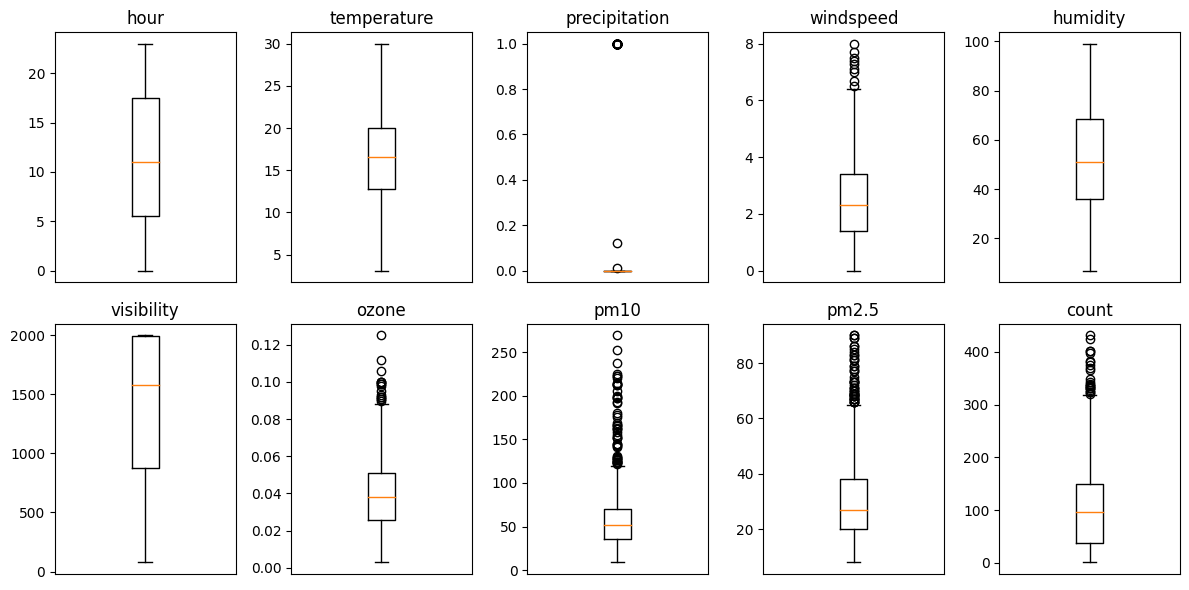

In [30]:
plt.figure(figsize = (12, 6))

for i, col in enumerate(train.columns[1:]):
    plt.subplot(2, 5, i + 1)
    plt.boxplot(train[col])
    plt.title(col)
    plt.xticks([])
    plt.tight_layout()
plt.show()

In [31]:
outlierDF = train.copy()

isof = IsolationForest(contamination = 0.05, random_state = 42)
outlierDF['anomaly'] = isof.fit_predict(outlierDF.drop(columns = ['id', 'precipitation', 'count'], errors = 'ignore'))
outlierISOF = outlierDF[outlierDF.anomaly == 1].drop(columns = ['anomaly'])

xISOF = outlierISOF.drop(columns = ['id', 'count'])
yISOF = outlierISOF['count']

X_trainISOF, X_valISOF, y_trainISOF, y_valISOF = train_test_split(xISOF, yISOF, test_size=0.2, random_state=42)

model_iso = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=2021) #LinearRegression()
model_iso.fit(X_trainISOF, y_trainISOF)
preds_iso = model_iso.predict(X_valISOF)
mse_iso = mean_squared_error(y_valISOF, preds_iso)

print(f'MSE (Isolation Forest): {mse_iso}')

MSE (Isolation Forest): 1633.5314065918571


In [32]:
outlierDF = train.copy()

mcd = EllipticEnvelope(contamination=0.1, random_state=42)
outlierDF['anomaly'] = mcd.fit_predict(outlierDF.drop(columns=['id', 'precipitation', 'count'], errors='ignore'))
outlierMCD = outlierDF[outlierDF['anomaly'] == 1].drop(columns=['anomaly'])

xMCD = outlierMCD.drop(columns=['id', 'count'])
yMCD = outlierMCD['count']

X_trainMCD, X_valMCD, y_trainMCD, y_valMCD = train_test_split(xMCD, yMCD, test_size=0.2, random_state=42)

model_mcd = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=2021) #LinearRegression()
model_mcd.fit(X_trainMCD, y_trainMCD)
preds_mcd = model_mcd.predict(X_valMCD)
mse_mcd = mean_squared_error(y_valMCD, preds_mcd)

print(f'MSE (MCD): {mse_mcd}')

MSE (MCD): 1561.1376000587097


In [33]:
outlierDF = train.copy()
exclude = ['id', 'precipitation', 'count']

Q1 = outlierDF.drop(columns=exclude).quantile(0.25)
Q3 = outlierDF.drop(columns=exclude).quantile(0.75)
IQR = Q3 - Q1

outlierIQR = outlierDF[~((outlierDF.drop(columns=exclude) < (Q1 - 1.5 * IQR)) | (outlierDF.drop(columns=exclude) > (Q3 + 1.5 * IQR))).any(axis=1)]

# 모델 학습 및 평가
xIQR = outlierIQR.drop(columns=['id', 'count'])
yIQR = outlierIQR['count']

X_trainIQR, X_valIQR, y_trainIQR, y_valIQR = train_test_split(xIQR, yIQR, test_size=0.2, random_state=42)

model_iqr = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=2021) #LinearRegression()
model_iqr.fit(X_trainIQR, y_trainIQR)
preds_iqr = model_iqr.predict(X_valIQR)
mse_iqr = mean_squared_error(y_valIQR, preds_iqr)

print(f'MSE (IQR): {mse_iqr}')

MSE (IQR): 1695.903950885642


In [34]:
results = pd.DataFrame({
    'Method': ['Isolation Forest', 'MCD', 'IQR'],
    'MSE': [mse_iso, mse_mcd, mse_iqr]
})

results

,Method,MSE
0,Isolation Forest,1633.531407
1,MCD,1561.137600
2,IQR,1695.903951


- MCD로 이상치 제거한 결과가 가장 좋다. 채택!

In [35]:
outlierMCD.groupby('hour')['precipitation'].mean()

hour
0.0     0.000212
1.0     0.049180
2.0     0.037037
3.0     0.018182
4.0     0.018519
5.0     0.018519
6.0     0.018182
7.0     0.018182
8.0     0.037037
9.0     0.019608
10.0    0.000000
11.0    0.000000
12.0    0.018519
13.0    0.018868
14.0    0.072727
15.0    0.072727
16.0    0.037736
17.0    0.089286
18.0    0.019698
19.0    0.035088
20.0    0.052632
21.0    0.017857
22.0    0.035714
23.0    0.000000
Name: precipitation, dtype: float64

In [36]:
# train = outlierISOF
train = outlierMCD

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1313 non-null   float64
 1   hour           1313 non-null   float64
 2   temperature    1313 non-null   float64
 3   precipitation  1313 non-null   float64
 4   windspeed      1313 non-null   float64
 5   humidity       1313 non-null   float64
 6   visibility     1313 non-null   float64
 7   ozone          1313 non-null   float64
 8   pm10           1313 non-null   float64
 9   pm2.5          1313 non-null   float64
 10  count          1313 non-null   float64
dtypes: float64(11)
memory usage: 123.1 KB


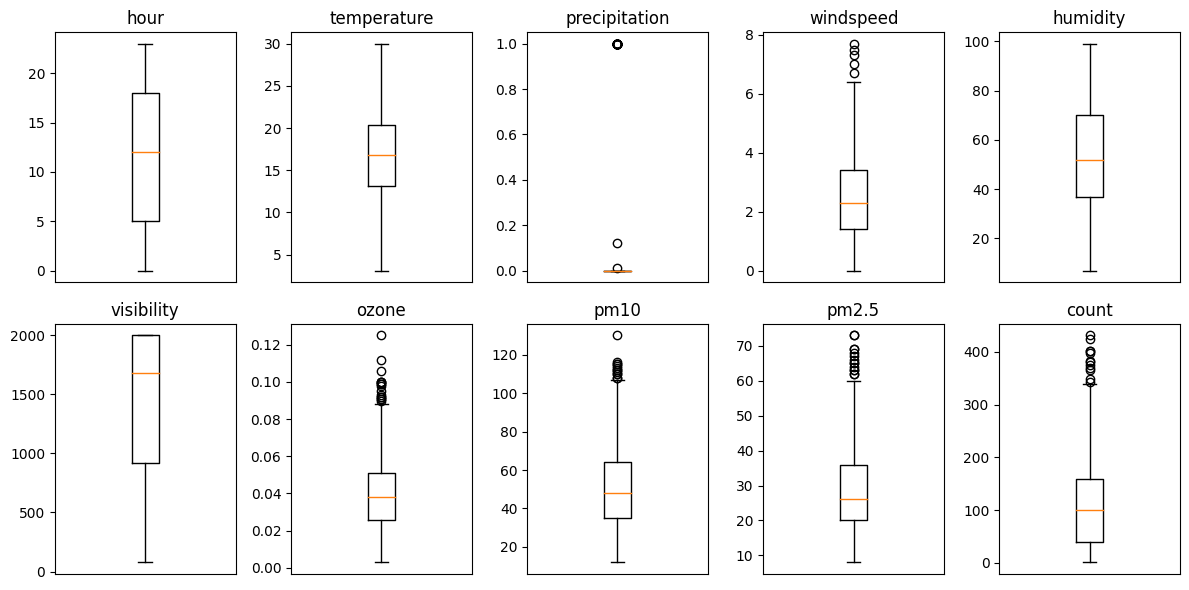

In [38]:
plt.figure(figsize = (12, 6))

for i, col in enumerate(train.columns[1:]):
    plt.subplot(2, 5, i + 1)
    plt.boxplot(train[col])
    plt.title(col)
    plt.xticks([])
    plt.tight_layout()
plt.show()

# 2. 데이터 평가 (EDA)

## 2-1. 분포, 왜도, 첨도

In [39]:
numCols = train.columns[1:]
numCols = list(numCols)

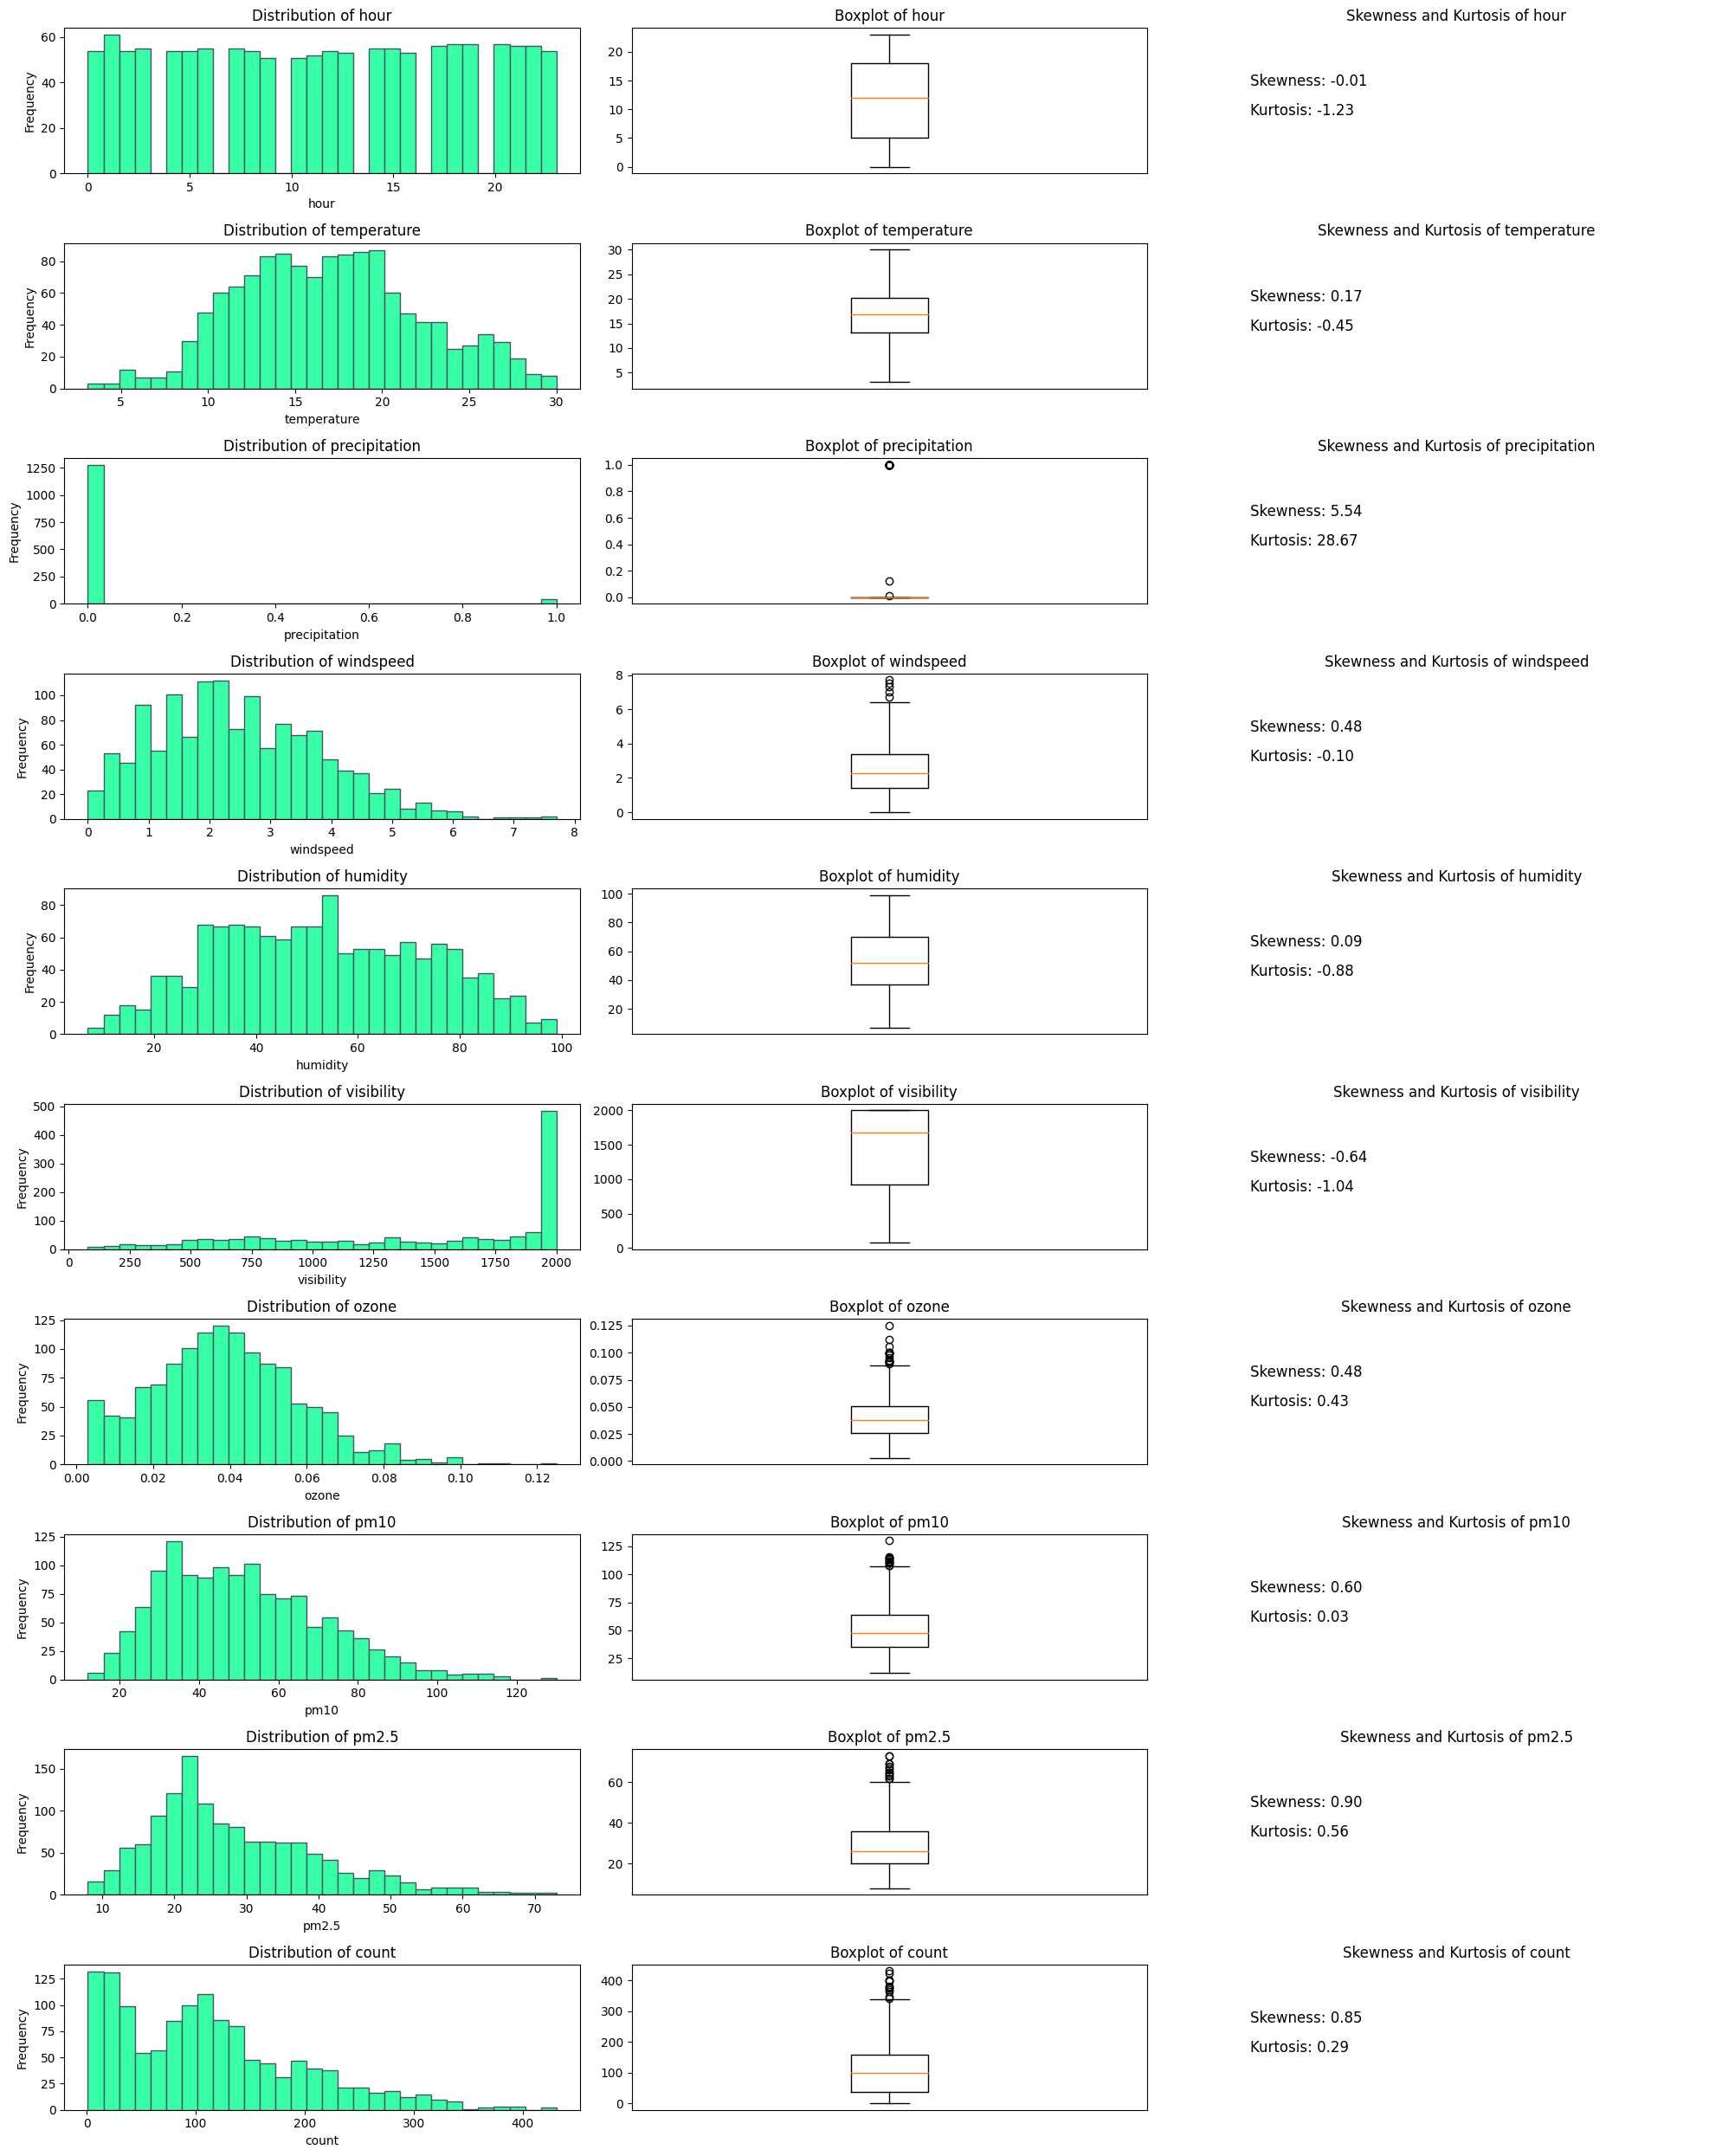

In [40]:
plt.figure(figsize=(20, 25))
for i, col in enumerate(numCols, 1):
    plt.subplot(len(numCols), 3, i*3-2)
    plt.hist(train[col].dropna(), bins=30, edgecolor=color[-1], color = color[0])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    plt.subplot(len(numCols), 3, i*3-1)
    plt.boxplot(train[col].dropna())
    plt.title(f'Boxplot of {col}')
    plt.xticks([])  # x축 레이블 제거
    
    plt.subplot(len(numCols), 3, i*3)
    skewness = skew(train[col].dropna())
    kurt = kurtosis(train[col].dropna())
    plt.text(0.1, 0.6, f'Skewness: {skewness:.2f}', fontsize=12)
    plt.text(0.1, 0.4, f'Kurtosis: {kurt:.2f}', fontsize=12)
    plt.title(f'Skewness and Kurtosis of {col}')
    plt.axis('off')  # 축 제거

plt.tight_layout()
plt.show()

In [41]:
xS = train.drop(columns=['id', 'visibility', 'count'])
yS = train['count']

X_trainS, X_valS, y_trainS, y_valS = train_test_split(xS, yS, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=2021) #LinearRegression()
model.fit(X_trainS, y_trainS)
predS = model.predict(X_valS)
mseS = mean_squared_error(y_valS, predS)

print(f'MSE (IQR): {mseS}')

MSE (IQR): 1549.0539874683875


In [42]:
x = train.drop(columns=['id', 'count'])
y = train['count']

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=2021) #LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_val)
mse = mean_squared_error(y_val, pred)

print(f'MSE (IQR): {mse}')

MSE (IQR): 1561.1376000587097


- 모든 변수가 예측에 영향을 미친다.

## 2-2. 시간별 평균 분포

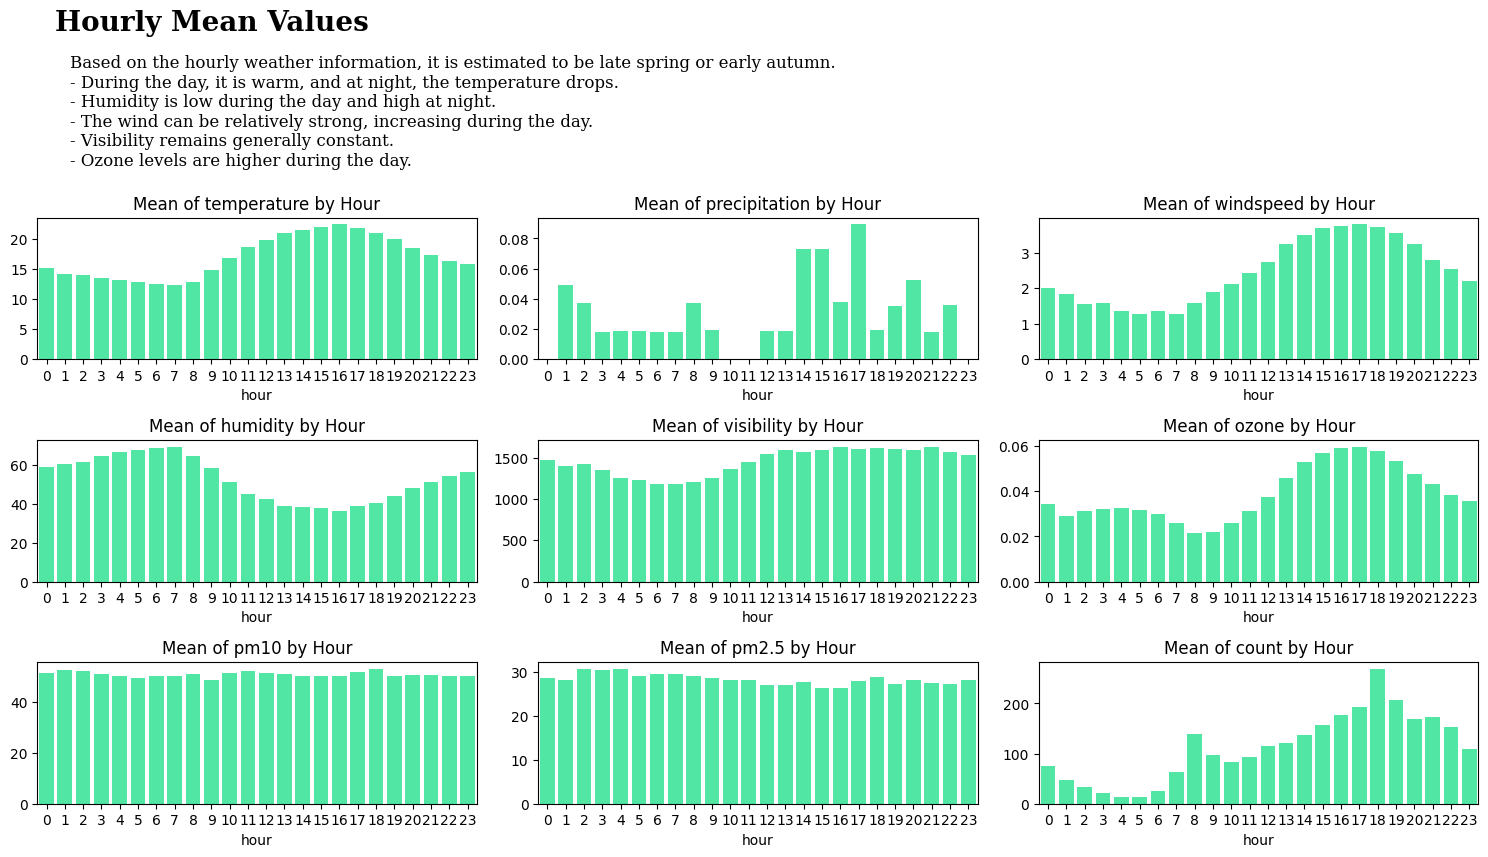

In [43]:
fig = plt.figure(figsize = (15,15))

for i, col in enumerate(train.columns[2:]):
    ax = plt.subplot(6, 3, i+1)
    grp = train.groupby('hour')[col].mean()
    # ax.plot(grp.index.astype(str), grp.values.astype, color = color[0])
    sns.barplot(x=grp.index.astype(int).astype(str), y=grp.values, color=color[0])
    ax.set_title(f"Mean of {col} by Hour")

    
fig.text(0.04, 1, 'Hourly Mean Values', fontsize=20, fontweight='bold', fontfamily='serif')
fig.text(0.05, 0.91
         , """Based on the hourly weather information, it is estimated to be late spring or early autumn.
- During the day, it is warm, and at night, the temperature drops.
- Humidity is low during the day and high at night.
- The wind can be relatively strong, increasing during the day.
- Visibility remains generally constant.
- Ozone levels are higher during the day."""
         , fontsize=12, fontweight='light', fontfamily='serif')
# fig.subplots_adjust(top=0.65)


# plt.tight_layout(pad=2.0)
plt.tight_layout(rect = [0, 0.03, 1, 0.90])
plt.show()

## 2-3. 시간대별 대여

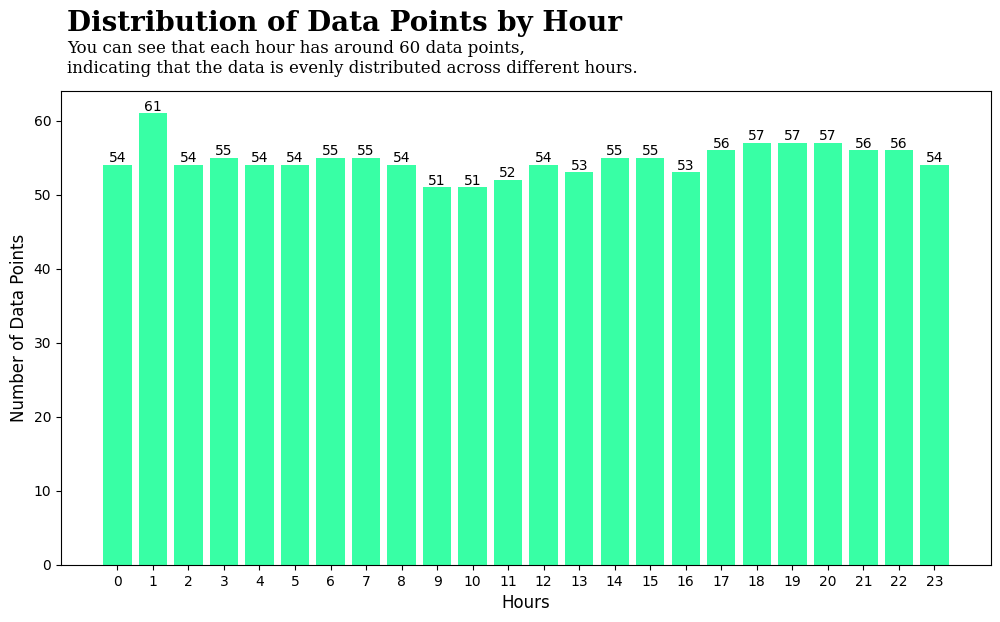

In [44]:
hours = train.groupby(['hour'])['hour'].count()

fig, ax = plt.subplots(1, 1, figsize = (12, 6))

fig.text(0.13, 1, 'Distribution of Data Points by Hour', fontsize=20, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.93
         , "You can see that each hour has around 60 data points, \nindicating that the data is evenly distributed across different hours."
         , fontsize=12, fontweight='light', fontfamily='serif')
fig.subplots_adjust(top=0.90)

bars = ax.bar(hours.index.astype(int).astype(str), hours.values, color = color[0])

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points') 

plt.xlabel('Hours', fontsize = 12)
plt.ylabel('Number of Data Points', fontsize = 12)
plt.show()

In [45]:
hours = train.groupby('hour')['count'].sum()
hoursRatio = hours / hours.sum() * 100
hoursRatio = hoursRatio.sort_values(ascending = False)
top3 = hoursRatio.head(3)
# print(hours)
# print(hoursRatio)
# print(top3)
# top8 = hoursRatio.head(8).iloc[3:8]
hoursRatio.index

Float64Index([18.0, 19.0, 17.0, 20.0, 21.0, 16.0, 15.0, 22.0,  8.0, 14.0, 13.0,
              12.0, 23.0,  9.0, 11.0, 10.0,  0.0,  7.0,  1.0,  2.0,  6.0,  3.0,
               4.0,  5.0],
             dtype='float64', name='hour')

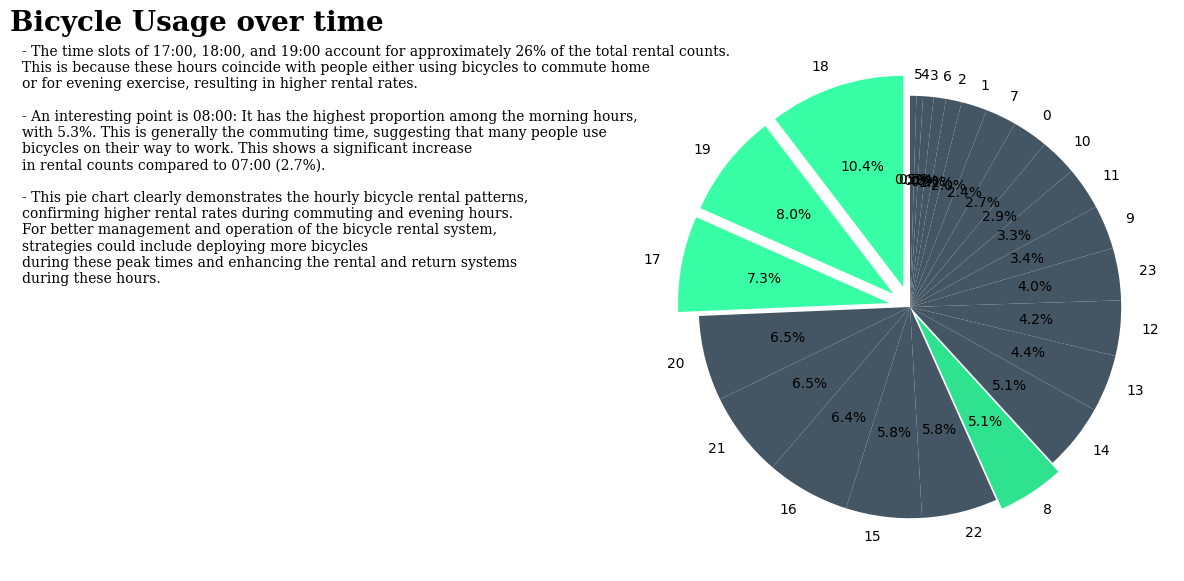

In [46]:
explode = [0.1 if hour in top3.index else 0.05 if hour == 8 else 0 for hour in hoursRatio.index]
colorCode = [color[0] if hour in top3.index else color[1] if hour == 8 else color[3] for hour in hoursRatio.index]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

fig.text(0.05, 1, 'Bicycle Usage over time', fontsize=20, fontweight='bold', fontfamily='serif')
fig.text(0.06, 0.58, 
f"""
- The time slots of 17:00, 18:00, and 19:00 account for approximately {top3.values[0]+top3.values[1]+top3.values[2]:.0f}% of the total rental counts. 
This is because these hours coincide with people either using bicycles to commute home 
or for evening exercise, resulting in higher rental rates.

- An interesting point is 08:00: It has the highest proportion among the morning hours, 
with 5.3%. This is generally the commuting time, suggesting that many people use 
bicycles on their way to work. This shows a significant increase 
in rental counts compared to 07:00 (2.7%).

- This pie chart clearly demonstrates the hourly bicycle rental patterns, 
confirming higher rental rates during commuting and evening hours. 
For better management and operation of the bicycle rental system, 
strategies could include deploying more bicycles
during these peak times and enhancing the rental and return systems 
during these hours."""
, fontsize=10, fontweight='light', fontfamily='serif')
# fig.subplots_adjust(top=0.80)
fig.subplots_adjust(left = 0, right = 1.6, top = 0.98, bottom = 0.1)

ax.pie(hoursRatio, labels = hoursRatio.index.astype(int), autopct='%1.1f%%', # counterclock = False,
        startangle=90, textprops=dict(color="black"), explode=explode, colors = colorCode)

plt.show()


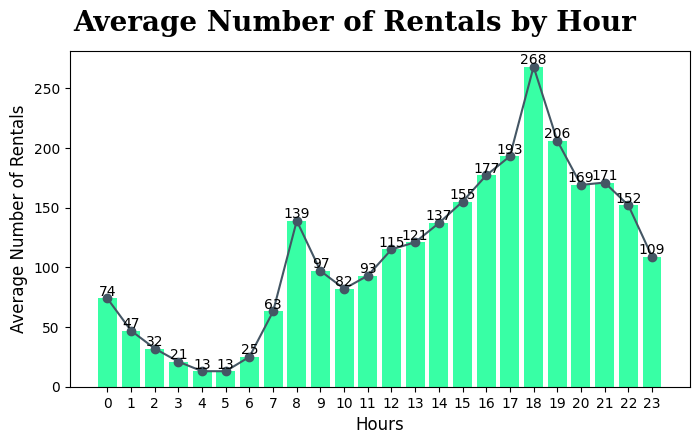

In [47]:
hours = train.groupby('hour')['count'].mean()

fig, ax = plt.subplots(1, 1, figsize = (8, 4))

fig.text(0.13, 1, 'Average Number of Rentals by Hour', fontsize=20, fontweight='bold', fontfamily='serif')
fig.subplots_adjust(top=0.95)

bars = ax.bar(hours.index.astype(int).astype(str), hours.values.astype(int), color = color[0])
line = ax.plot(hours.index.astype(int).astype(str), hours.values.astype(int), color= color[-1], marker='o')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points') 

plt.xlabel('Hours', fontsize = 12)
plt.ylabel('Average Number of Rentals', fontsize = 12)
plt.show()

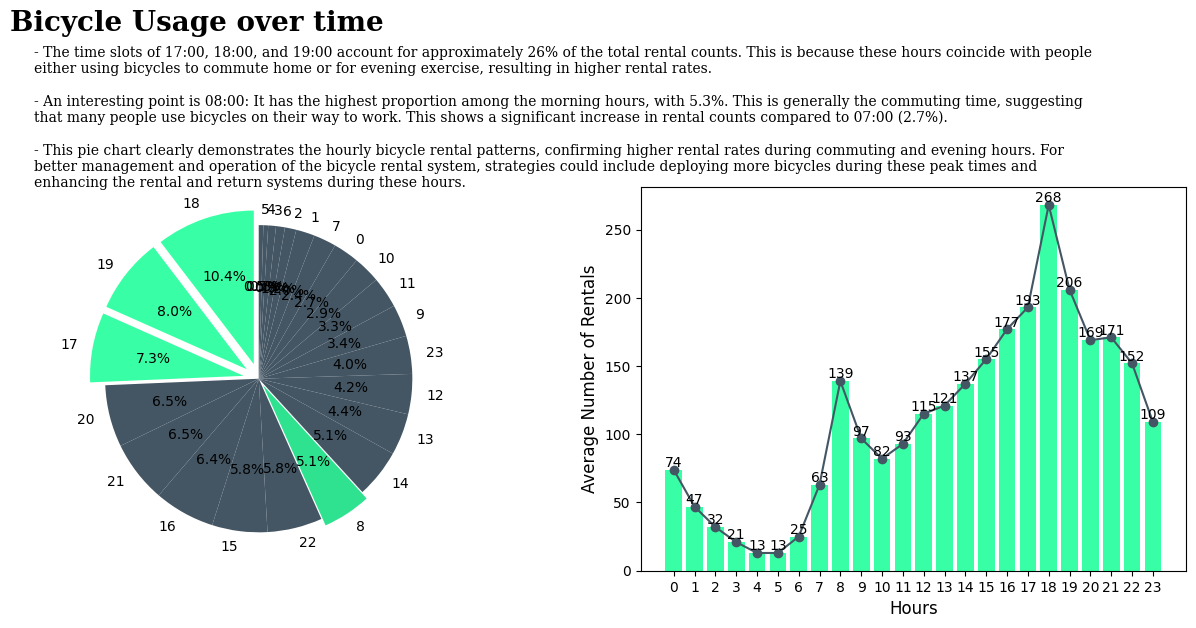

In [48]:
hours = train.groupby('hour')['count'].mean()

explode = [0.1 if hour in top3.index else 0.05 if hour == 8 else 0 for hour in hoursRatio.index]
colorCode = [color[0] if hour in top3.index else color[1] if hour == 8 else color[3] for hour in hoursRatio.index]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

fig.text(0.02, 1, 'Bicycle Usage over time', fontsize=20, fontweight='bold', fontfamily='serif')
fig.text(0.04, 0.74, 
f"""
- The time slots of 17:00, 18:00, and 19:00 account for approximately {top3.values[0]+top3.values[1]+top3.values[2]:.0f}% of the total rental counts. This is because these hours coincide with people 
either using bicycles to commute home or for evening exercise, resulting in higher rental rates.

- An interesting point is 08:00: It has the highest proportion among the morning hours, with 5.3%. This is generally the commuting time, suggesting 
that many people use bicycles on their way to work. This shows a significant increase in rental counts compared to 07:00 (2.7%).

- This pie chart clearly demonstrates the hourly bicycle rental patterns, confirming higher rental rates during commuting and evening hours. For 
better management and operation of the bicycle rental system, strategies could include deploying more bicycles during these peak times and 
enhancing the rental and return systems during these hours."""
, fontsize=10, fontweight='light', fontfamily='serif')
fig.subplots_adjust(left = 0, right = 1, top = 0.74, bottom = 0.1)
ax1.pie(hoursRatio, labels = hoursRatio.index.astype(int), autopct='%1.1f%%', # counterclock = False,
        startangle=90, textprops=dict(color="black"), explode=explode, colors = colorCode)

bars = ax2.bar(hours.index.astype(int).astype(str), hours.values.astype(int), color = color[0])
line = ax2.plot(hours.index.astype(int).astype(str), hours.values.astype(int), color= color[-1], marker='o')

for p in ax2.patches:
# for p in bars:
    height = p.get_height()
    ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points') 

plt.xlabel('Hours', fontsize = 12)
plt.ylabel('Average Number of Rentals', fontsize = 12)
plt.show()


## 2-4. 대여량 많은 시간 변수 추가 (df = busyTrain)

In [49]:
def busyHour(df, col):
    data = df.copy()
    lst = df[col]
    lst_ = []
    for i in lst:
        if (6 < i < 10) or (16 < i < 20):
            lst_.append(1)
        else:
            lst_.append(0)
    data['busyHour'] = lst_
    return data

busyTrain = busyHour(train, 'hour')
busyTrain.head()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,busyHour
0,3.0,20.0,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0,0
1,6.0,13.0,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0,0
2,7.0,6.0,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0,0
4,9.0,18.0,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0,1
5,13.0,2.0,13.6,0.0,1.7,80.0,1073.0,0.027,34.0,15.0,39.0,0


In [50]:
train.head()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
0,3.0,20.0,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6.0,13.0,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7.0,6.0,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
4,9.0,18.0,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
5,13.0,2.0,13.6,0.0,1.7,80.0,1073.0,0.027,34.0,15.0,39.0


## 2-5. 기온 별 자전거 대여 수

In [51]:
display(train.head())

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
0,3.0,20.0,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6.0,13.0,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7.0,6.0,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
4,9.0,18.0,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
5,13.0,2.0,13.6,0.0,1.7,80.0,1073.0,0.027,34.0,15.0,39.0


In [52]:
# 기온별 대여 횟수를 알기 위해 기온을 정수로 변환
train['temperature'] = train['temperature'].astype(int)

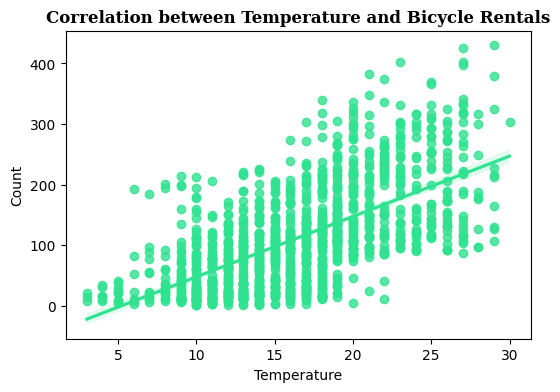

In [53]:
plt.figure(figsize=(6, 4))
sns.regplot(x = 'temperature', y = 'count', data = train, color = color[1])
plt.title("Correlation between Temperature and Bicycle Rentals", fontfamily = 'serif', fontweight = 'bold', fontsize = 12)
plt.xlabel("Temperature")
plt.ylabel("Count")
plt.show()

- As the temperature increases, there is a tendency for the number of bicycle rentals to increase. This suggests that people tend to rent more bicycles when the weather is warm.
- The number of bicycle rentals is also low when the temperature is low (below approximately 5 degrees) and when it is high (above approximately 25 degrees). This indicates that bicycle rentals may decrease during very cold or very hot weather.
- Overall, there is a positive correlation between temperature and the number of bicycle rentals. This indicates that as the temperature rises, the number of bicycle rentals tends to increase.
- 기온이 상승할수록 자전거 대여 수가 증가하는 경향이 있습니다. 날씨가 따뜻할 때 사람들이 더 많이 자전거를 대여하는 경향이 있음을 시사합니다.
- 기온이 낮은 경우(약 5도 이하)와 기온이 높은 경우(약 25도 이상)에도 자전거 대여 수가 낮은 편입니다. 매우 추운 날씨나 매우 더운 날씨에는 자전거 대여가 줄어들 수 있음을 보여줍니다.
- 전반적으로, 기온과 자전거 대여 수는 양의 상관관계를 보입니다. 이는 기온이 오를수록 자전거 대여 수가 증가하는 경향이 있음을 나타냅니다.

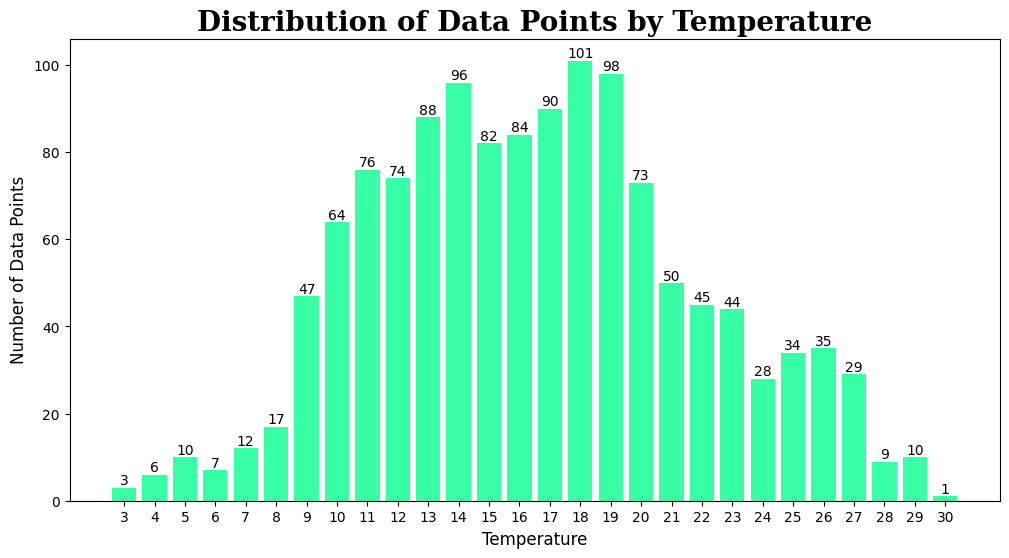

In [54]:
temperature = train.groupby(['temperature'])['temperature'].count()

fig, ax = plt.subplots(1, 1, figsize = (12, 6))
bars = ax.bar(temperature.index.astype(str), temperature.values, color = color[0])

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points') 
plt.title('Distribution of Data Points by Temperature', fontsize=20, fontweight='bold', fontfamily='serif')
plt.xlabel('Temperature', fontsize = 12)
plt.ylabel('Number of Data Points', fontsize = 12)
plt.show()

기온 컬럼은 시간 컬럼과 다르게 데이터가 균등하지 않기 때문에 기온별 총 대여 횟수가 아닌 평균 대여 횟수를 보는 건 분석에 적절하지 않다.

In [55]:
temperature = train.groupby('temperature')['count'].sum().astype(int)
temperRatio = temperature / temperature.sum() * 100
top5 = temperRatio.sort_values(ascending = False).head()
# temperRatio.sort_values(ascending = False)
top10 = temperRatio.sort_values(ascending = False).head(10).iloc[5:10]
print(top5)
print(top10)

temperature
19    9.378448
20    8.241769
18    7.915457
17    5.977212
23    5.903420
Name: count, dtype: float64
temperature
21    5.804578
22    5.517531
16    5.166846
14    5.055141
25    4.986088
Name: count, dtype: float64


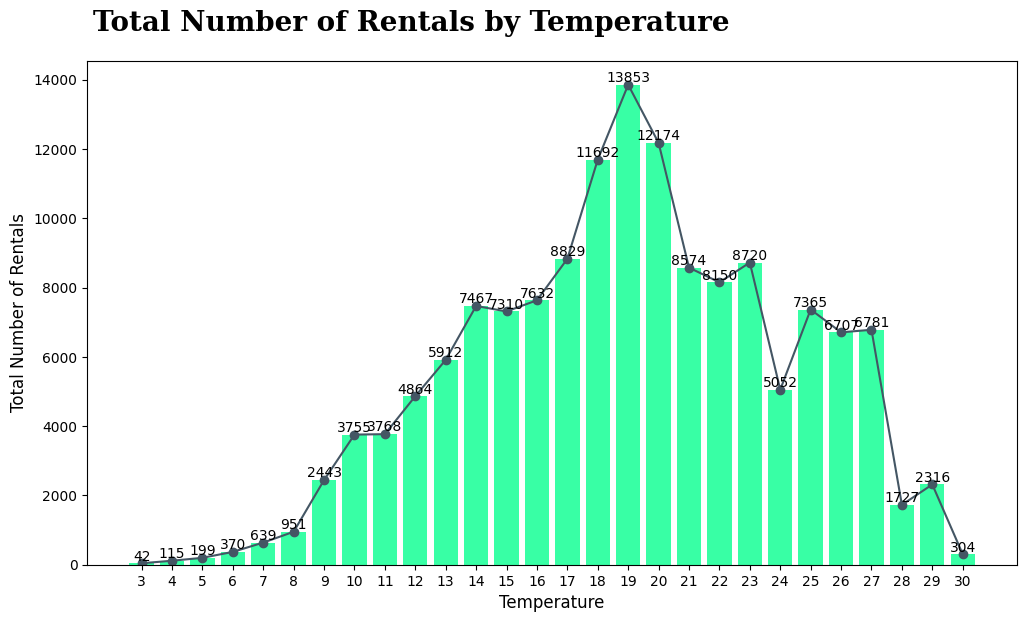

In [56]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

fig.text(0.13, 1, 'Total Number of Rentals by Temperature', fontsize=20, fontweight='bold', fontfamily='serif')
fig.subplots_adjust(top=0.95)

bars = ax.bar(temperature.index.astype(str), temperature.values.astype(int), color = color[0])
line = ax.plot(temperature.index.astype(str), temperature.values.astype(int), color= color[-1], marker='o')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points') 

plt.xlabel('Temperature', fontsize = 12)
plt.ylabel('Total Number of Rentals', fontsize = 12)
plt.show()

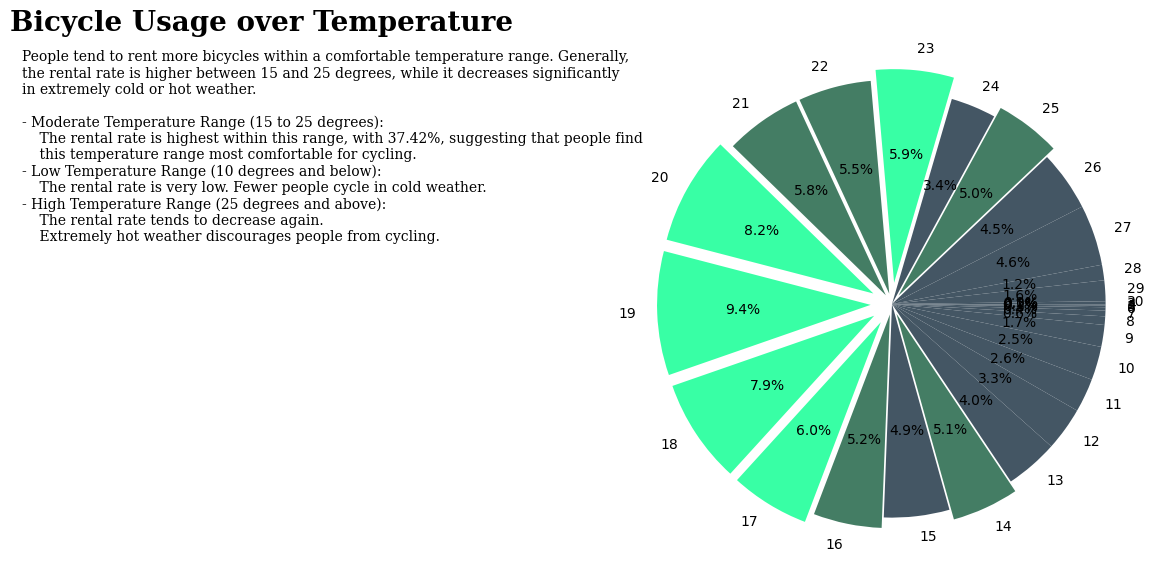

In [57]:
explode = [0.1 if temperature in top5.index else 0.05 if temperature in top10.index else 0 for temperature in temperRatio.index]
colorCode = [color[0] if temperature in top5.index else color[2] if temperature in top10.index else color[3] for temperature in temperRatio.index]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

fig.text(0.13, 1, 'Bicycle Usage over Temperature', fontsize=20, fontweight='bold', fontfamily='serif')
fig.text(0.14, 0.65, 
f"""People tend to rent more bicycles within a comfortable temperature range. Generally, 
the rental rate is higher between 15 and 25 degrees, while it decreases significantly 
in extremely cold or hot weather.

- Moderate Temperature Range (15 to 25 degrees): 
    The rental rate is highest within this range, with {top5.values[0]+top5.values[1]+top5.values[2]+top5.values[3]+top5.values[4]:.2f}%, suggesting that people find 
    this temperature range most comfortable for cycling.
- Low Temperature Range (10 degrees and below): 
    The rental rate is very low. Fewer people cycle in cold weather.
- High Temperature Range (25 degrees and above): 
    The rental rate tends to decrease again. 
    Extremely hot weather discourages people from cycling."""
         , fontsize=10, fontweight='light', fontfamily='serif')
# fig.subplots_adjust(top=0.80)

fig.subplots_adjust(left = 0.13, right = 1.6, top = 0.99, bottom = 0.1)

ax.pie(temperRatio, labels = temperRatio.index, autopct='%1.1f%%', counterclock = False,
        startangle=0, textprops=dict(color="black"), explode=explode, colors = colorCode)

plt.show()

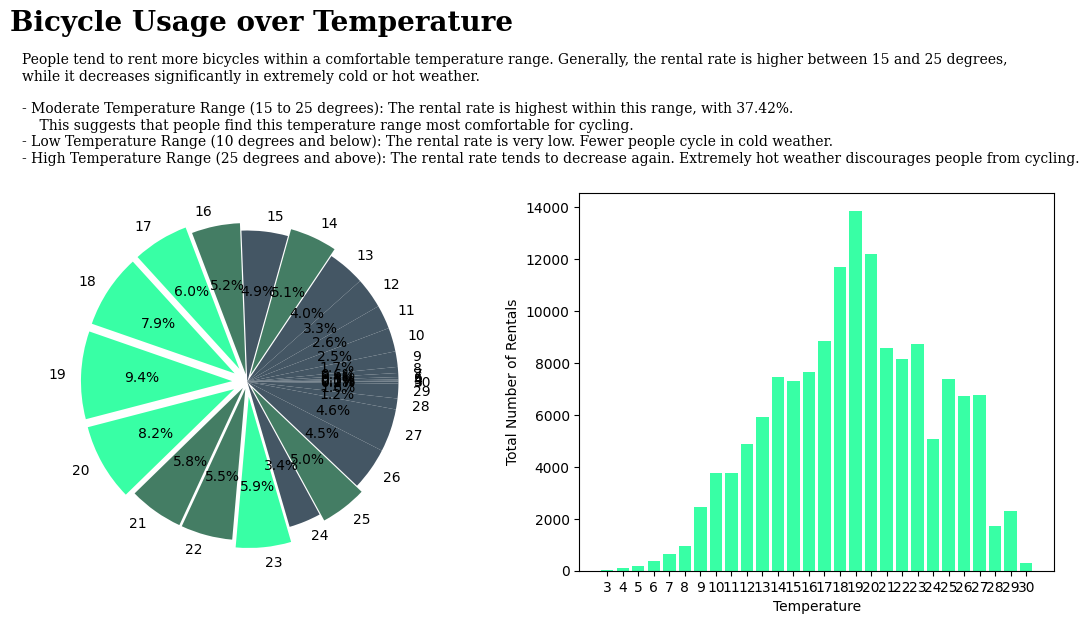

In [58]:
explode = [0.1 if temperature in top5.index else 0.05 if temperature in top10.index else 0 for temperature in temperRatio.index]
colorCode = [color[0] if temperature in top5.index else color[2] if temperature in top10.index else color[3] for temperature in temperRatio.index]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

fig.text(0.13, 1, 'Bicycle Usage over Temperature', fontsize=20, fontweight='bold', fontfamily='serif')
fig.text(0.14, 0.78, 
f"""People tend to rent more bicycles within a comfortable temperature range. Generally, the rental rate is higher between 15 and 25 degrees, 
while it decreases significantly in extremely cold or hot weather.

- Moderate Temperature Range (15 to 25 degrees): The rental rate is highest within this range, with {top5.values[0]+top5.values[1]+top5.values[2]+top5.values[3]+top5.values[4]:.2f}%.
    This suggests that people find this temperature range most comfortable for cycling.
- Low Temperature Range (10 degrees and below): The rental rate is very low. Fewer people cycle in cold weather.
- High Temperature Range (25 degrees and above): The rental rate tends to decrease again. Extremely hot weather discourages people from cycling."""
, fontsize=10, fontweight='light', fontfamily='serif')
fig.subplots_adjust(left = 0.13, right = 1, top = 0.73, bottom = 0.1)
ax1.pie(temperRatio, labels = temperRatio.index, autopct='%1.1f%%', # counterclock = False,
        startangle=0, textprops=dict(color="black"), explode=explode, colors = colorCode)

bars = ax2.bar(temperature.index.astype(str), temperature.values.astype(int), color = color[0])

# for p in ax2.patches:
# # for p in bars:
#     height = p.get_height()
#     ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points') 

plt.xlabel('Temperature', fontsize = 10)
plt.ylabel('Total Number of Rentals', fontsize = 10)
plt.show()


사람들이 자전거를 타기에 적당한 온도 범위에서 대여가 많이 이루어집니다. 대체로 15도에서 25도 사이의 기온에서 자전거 대여 비율이 높으며, 너무 춥거나 너무 더운 날씨에서는 대여 비율이 낮아지는 경향을 확인할 수 있습니다.
- 중간 기온대(15도에서 25도 사이): 이 구간에서 자전거 대여 비율이 가장 높습니다. 이는 사람들이 일반적으로 자전거를 타기에 편안한 온도대임을 예상할 수 있습니다.
- 낮은 기온대(10도 이하): 자전거 대여 비율이 매우 낮습니다. 추운 날씨에서는 자전거를 타는 사람들이 적습니다.
- 높은 기온대(25도 이상): 대여 비율이 다시 낮아지는 경향이 있습니다. 매우 더운 날씨에서는 자전거를 타는 사람들이 줄어듭니다.

## 2-6. 미세먼지 수준 별 대여 수

In [59]:
pmDF = train[['pm10', 'pm2.5', 'count']]
pmDF.head()

,pm10,pm2.5,count
0,76.0,33.0,49.0
1,73.0,40.0,159.0
2,32.0,19.0,26.0
4,27.0,11.0,431.0
5,34.0,15.0,39.0


              pm10        pm2.5        count
count  1313.000000  1313.000000  1313.000000
mean     51.005311    28.321463   112.498858
std      20.099171    11.612931    84.280565
min      12.000000     8.000000     1.000000
25%      35.000000    20.000000    39.000000
50%      48.000000    26.000000   101.000000
75%      64.000000    36.000000   159.000000
max     130.000000    73.000000   431.000000


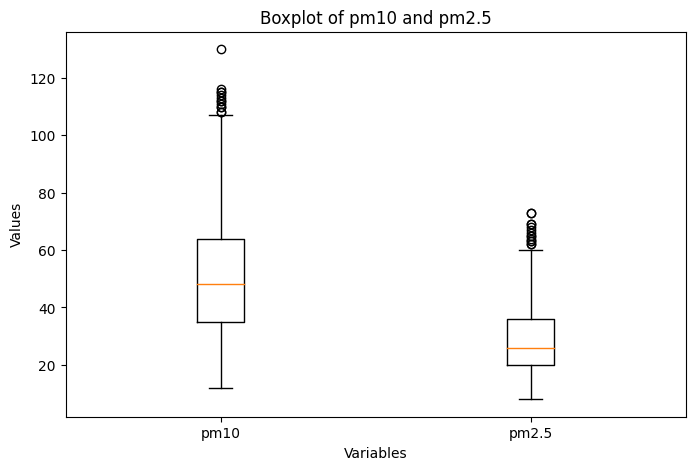

In [60]:
print(pmDF.describe())
plt.figure(figsize =(8,5))
plt.boxplot([pmDF['pm10'], pmDF['pm2.5']], labels = ['pm10', 'pm2.5'])
plt.title('Boxplot of pm10 and pm2.5')
plt.xlabel('Variables')
plt.ylabel('Values')
plt.show()

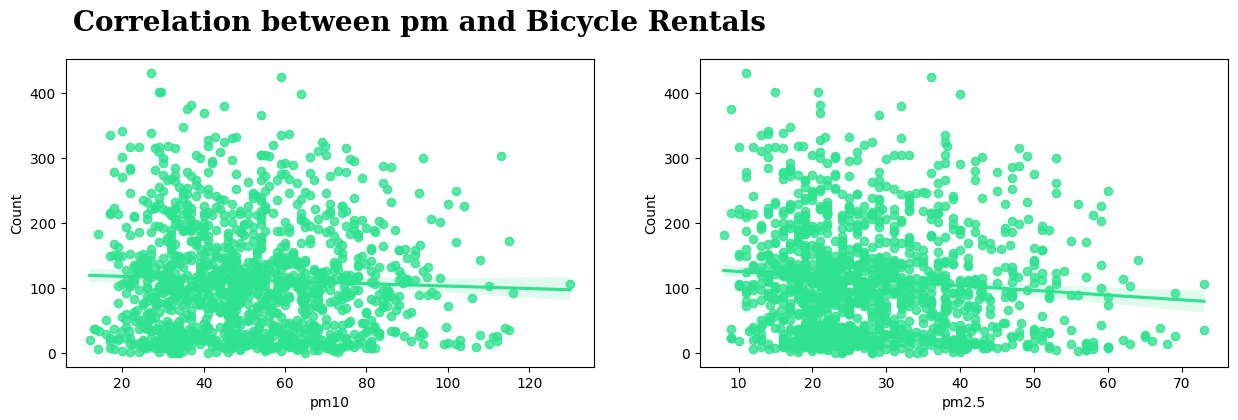

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))

sns.regplot(x = 'pm10', y = 'count', data = pmDF, color = color[1], ax = ax1)
fig.text(0.13, 0.95, "Correlation between pm and Bicycle Rentals", fontfamily = 'serif', fontweight = 'bold', fontsize = 20)
# fig.subplots_adjust(top=0.92)
# fig.subplots_adjust(left = 0.13, right = 1, top = 0.92, bottom = 0.1)
ax1.set_xlabel("pm10")
ax1.set_ylabel("Count")

sns.regplot(x = 'pm2.5', y = 'count', data = pmDF, color = color[1], ax = ax2)
ax2.set_xlabel("pm2.5")
ax2.set_ylabel("Count")

# plt.tight_layout()
plt.show()

In [62]:
# len(train['pm10'].unique())
# len(train['pm2.5'].unique())
train['pm10'].sort_values()

394      12.000000
68       13.000000
1165     13.190301
10       14.000000
1137     14.000000
           ...    
374     114.000000
614     115.000000
60      115.000000
644     116.000000
622     130.000000
Name: pm10, Length: 1313, dtype: float64

**미세먼지 농도 범위를 정의하기**


1. 미세먼지 (PM10)
- Good (좋음): 미세먼지 농도가 0 ~ 30 μg/m³
- Not Bad (보통): 미세먼지 농도가 31 ~ 80 μg/m³
- Bad (나쁨): 미세먼지 농도가 81 ~ 150 μg/m³
- Very Bad (매우 나쁨): 미세먼지 농도가 151 μg/m³ 이상

2. 초미세먼지(PM2.5)
- Good (좋음): 미세먼지 농도가 0 ~ 15 μg/m³
- Not Bad (보통): 미세먼지 농도가 16 ~ 35 μg/m³
- Bad (나쁨): 미세먼지 농도가 36 ~ 75 μg/m³
- Very Bad (매우 나쁨): 미세먼지 농도가 76 μg/m³ 이상


In [63]:
pmDF['pm10'] = pmDF['pm10'].apply(lambda x: 
                                'Very bad' if x >= 151
                                else 'Bad' if x >= 81
                                else 'Not bad' if x >= 31 
                                else 'Good')
pmDF['pm2.5'] = pmDF['pm2.5'].apply(lambda x: 
                                'Very bad' if x >= 76
                                else 'Bad' if x >= 36
                                else 'Not bad' if x >= 16 
                                else 'Good')

In [64]:
# test['pm10'] = test['pm10'].apply(lambda x: 
#                                 'Very bad' if x >= 151
#                                 else 'Bad' if x >= 81
#                                 else 'Not bad' if x >= 31 
#                                 else 'Good')
# test['pm2.5'] = test['pm2.5'].apply(lambda x: 
#                                 'Very bad' if x >= 76
#                                 else 'Bad' if x >= 36
#                                 else 'Not bad' if x >= 16 
#                                 else 'Good')

In [65]:
# pmDF = train[['pm10', 'pm2.5', 'count']]
pmDF.head()

,pm10,pm2.5,count
0,Not bad,Not bad,49.0
1,Not bad,Bad,159.0
2,Not bad,Not bad,26.0
4,Good,Good,431.0
5,Not bad,Good,39.0


In [66]:
pmGrouped = pmDF.groupby(['pm10', 'pm2.5'])['count'].sum().reset_index()
# pmGrouped = pmDF.groupbu(['pm10', 'pm2.5']).agg({'count': 'sum'}).reset_index()
pmGrouped

,pm10,pm2.5,count
0,Bad,Bad,9454.0
1,Bad,Not bad,2611.0
2,Good,Bad,21.0
3,Good,Good,9229.0
4,Good,Not bad,14202.0
5,Not bad,Bad,25174.0
6,Not bad,Good,8109.0
7,Not bad,Not bad,78911.0


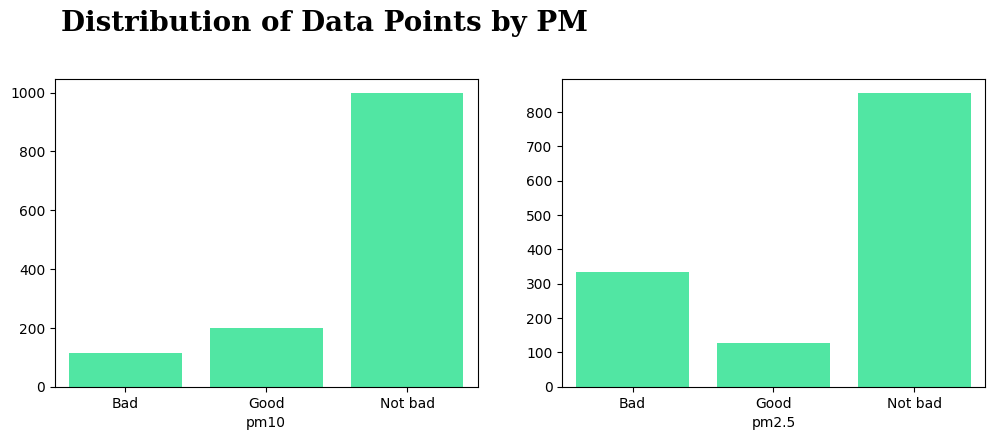

In [67]:
fig = plt.figure(figsize = (12, 4))

for i, pm in enumerate(pmDF.columns[:2]):
    ax = plt.subplot(1, 2, i+1)
    grp = pmDF.groupby(pm)[pm].count()
    sns.barplot(x = grp.index, y = grp.values, color = color[0])
    
fig.text(0.13, 1, 'Distribution of Data Points by PM', fontsize=20, fontweight='bold', fontfamily='serif')
plt.show()

plt.show()


In [68]:
pm10Group = pmDF.groupby(['pm10', 'pm2.5'])['count'].sum().unstack().fillna(0).astype(int)
pm2Group = pmDF.groupby(['pm2.5', 'pm10'])['count'].sum().unstack().fillna(0).astype(int)

display(pm10Group, pm2Group)

pm2.5,Bad,Good,Not bad
pm10,,,
Bad,9454,0,2611
Good,21,9229,14202
Not bad,25174,8109,78911


pm10,Bad,Good,Not bad
pm2.5,,,
Bad,9454,21,25174
Good,0,9229,8109
Not bad,2611,14202,78911


In [69]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
# fig.text(0.13, 0.95, "Number of Bicycle Rentals by PM10 X PM2.5", fontsize = 20, fontweight = 'bold', fontfamily = 'serif')
# fig.subplots_adjust(top = 0.93)

# # pm10으로 그룹화 -> pm2.5 스택 

# for key, val in pmGrouped.groupby(['pm10']):
#     ax1.bar(val['pm2.5'], val['count'], label = key)
# for p in ax1.patches:
#     height = p.get_height()
#     ax1.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize = 8) 
# ax1.set_xlabel("pm10", fontsize = 10)
# ax1.set_ylabel("Total Number of Rentals", fontsize = 10)
# ax1.set_yticklabels(ax1.get_yticklabels(), fontsize = 8)
# ax1.legend(title='pm2.5')

# # pm2.5로 그룹화 -> pm10 스택
# for key, val in pmGrouped.groupby(['pm2.5']):
#     ax2.bar(val['pm10'], val['count'], label = key)
# for p in ax2.patches:
#     height = p.get_height()
#     ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize = 8) 
# # ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 0)
# ax2.set_xlabel("pm2.5", fontsize = 10)
# ax2.set_ylabel("Total Number of Rentals", fontsize = 10)
# ax2.set_yticklabels(ax1.get_yticklabels(), fontsize = 8)
# ax2.legend(title='pm10')

# # ax1.set_facecolor('white')
# # ax2.set_facecolor('white')
# # ax1.grid(False)
# # ax2.grid(False)

# plt.show()

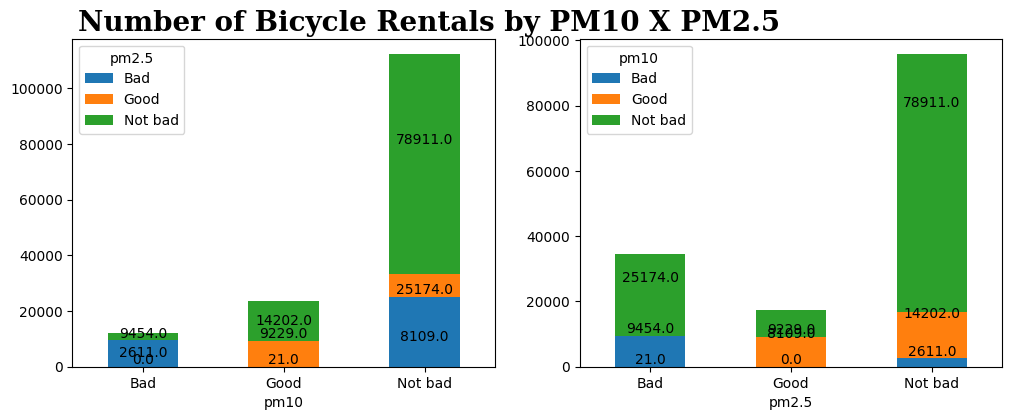

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
fig.text(0.13, 0.95, "Number of Bicycle Rentals by PM10 X PM2.5", fontsize = 20, fontweight = 'bold', fontfamily = 'serif')
fig.subplots_adjust(top = 0.93)

# pm10으로 그룹화 -> pm2.5 스택 

pm10Group.plot(kind = 'bar', stacked = True, ax=ax1) #, color = color)
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points') 
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 0)

# pm2.5로 그룹화 -> pm10 스택
pm2Group.plot(kind = 'bar', stacked = True, ax=ax2) #, color = color)
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points') 
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 0)
plt.show()

보기 좋지가 않군요

In [71]:
pmGrouped

,pm10,pm2.5,count
0,Bad,Bad,9454.0
1,Bad,Not bad,2611.0
2,Good,Bad,21.0
3,Good,Good,9229.0
4,Good,Not bad,14202.0
5,Not bad,Bad,25174.0
6,Not bad,Good,8109.0
7,Not bad,Not bad,78911.0


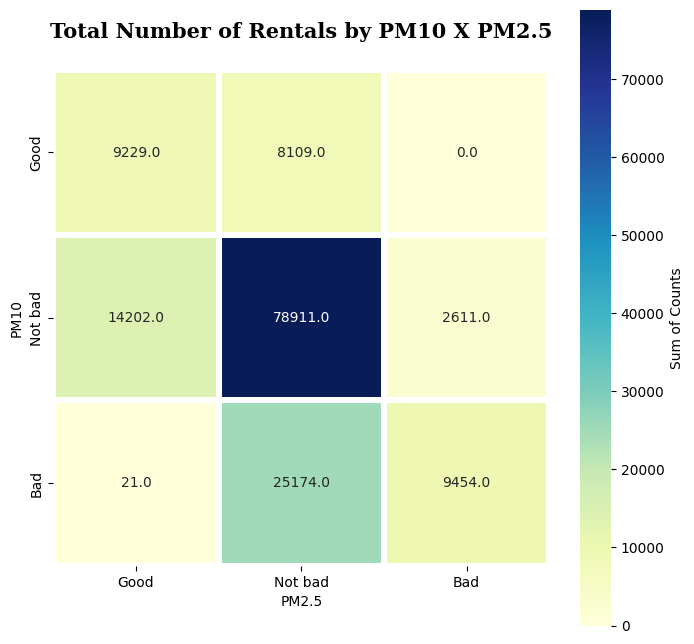

In [72]:
pmOrder = ['Good', 'Not bad', 'Bad']


plt.figure(figsize=(8, 8))
# sns.set(font_scale=1.2)
sns.heatmap(pm2Group.loc[pmOrder, pmOrder], # train.pivot_table(values='count', index=['pm2.5'], columns=['pm10'], aggfunc=np.sum).loc[pmOrder, pmOrder],
            linewidth=4, 
            # ax=ax, 
            square=True,
            annot=True, 
            fmt=".1f", 
            cmap="YlGnBu",
            # cmap = color,
            cbar_kws={'label': 'Sum of Counts'}
           )
plt.title('Total Number of Rentals by PM10 X PM2.5\n', fontsize = 15, fontfamily = 'serif', fontweight = 'bold')
plt.xlabel('PM2.5')
plt.ylabel('PM10')
# plt.tight_layout()
plt.show()

1. PM10과 PM2.5가 모두 Good일 때: 데이터에서 PM10이 Good일 때의 전체 자전거 대여량은 11.3%로, 생각보다 낮습니다. PM10이 Good일 때의 자전거 대여량은 전반적으로 낮은 편입니다.
2. PM10과 PM2.5가 모두 Not bad일 때:
- 자전거 대여량이 가장 높습니다. 이 조합에서 자전거 대여가 매우 활발하게 이루어지고 있습니다.
- 이는 공기 질이 상대적으로 괜찮을 때 사람들이 자전거를 많이 대여하는 경향이 있음을 나타낼 수 있습니다. 하지만, 이 조건 자체가 자전거 대여를 잘 예측할 수 있는 조건이라고 보기는 어렵습니다. 데이터에 포함되지 않은 다른 조건들(예: 날짜, 다른 날씨 조건 등)이 더 중요한 영향을 미칠 수 있습니다.

##### 결론
- PM10과 PM2.5가 Good일 때는 자전거 대여량에 큰 영향을 미치지 못했으며, PM10이 Good일 때의 자전거 대여량은 전체의 약 11.3%로 낮은 편입니다.
- PM10과 PM2.5가 모두 Not bad일 때 가장 높은 대여량을 보이고 있습니다. 이는 공기 질이 상대적으로 괜찮을 때 사람들이 자전거를 많이 대여하는 경향을 나타낼 수 있지만, 자전거 대여를 잘 예측할 수 있는 조건이라고 보기는 어렵습니다. 데이터에 포함되지 않은 다른 조건들(예: 날짜, 다른 날씨 조건 등)이 더 중요할 수 있습니다.

- 미세먼지 pm10 기준, 공기의 질이 보통(not bad)일 때와 좋을(good) 때에 비해 나쁜 수준(bad, very bad)일 때 자전거 대여 수가 급격히 감소하는 경향성.
- 초미세먼지 pm2.5 기준, 공기의 질이 나쁠수록 (Not Bad -> Bad -> Very Bad) 자전거 대여 수가 급격히 감소하는 경향성.
    - 초미세먼지 수준이 보통 (not bad)일 때 가장 많은 대여 발생
    - \[!\] 초미세먼지 수준이 나쁠 (bad) 때 좋을 때보다 더 많은 대여 발생

- 미세먼지 농도와 자전거 대여 수 간에는 일정한 상관관계가 있을 수 있음.
- 특히 공기 질이 매우 나쁠 때 자전거 대여 수가 두드러지게 감소하는 경향을 확인할 수 있음.
    - 그러나 초미세먼지 수준이 나쁜 수준일 때에도 좋은 수준일 때보다 약 2배 가량의 높은 대여를 확인할 수 있음.
    - 미세먼지 농도가 자전거 대여에 "극적인" 영향을 미친다고 단정하기는 어려움.
    - 상황에 따라 영향력의 정도가 다를 수 있으며, 추가적인 데이터 분석과 다른 환경적, 계절적 요인 고려 필요.

## 2-7. 전체 변수 특성 중요도

36.91048169387939


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

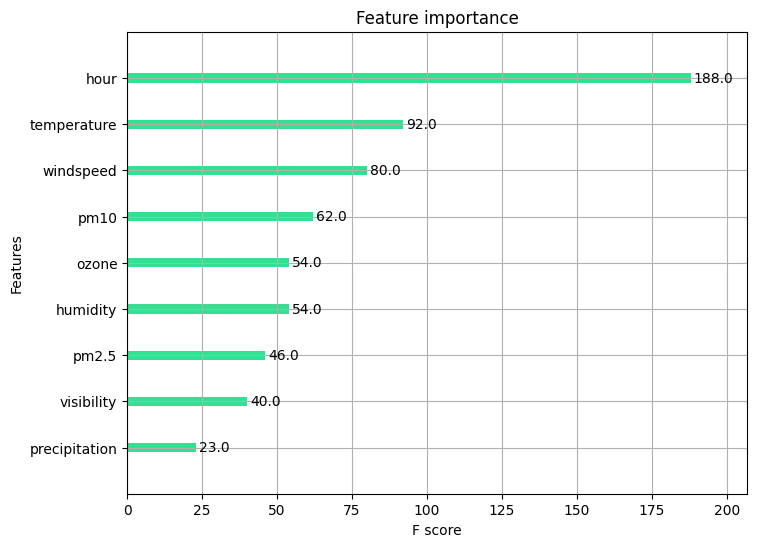

In [73]:
x = train.drop(columns = ['id', 'count'])
y = train['count']

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 2021)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=2021)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, pred))
print(rmse)

fig, ax = plt.subplots(figsize = (8,6))
plot_importance(xgb, ax=ax, color = color[1])

## 2-8. 상관관계

count            1.000000
hour             0.638884
temperature      0.622067
ozone            0.495747
windspeed        0.483339
visibility       0.286594
id              -0.005649
pm10            -0.044665
pm2.5           -0.100187
precipitation   -0.158190
humidity        -0.505527
Name: count, dtype: float64


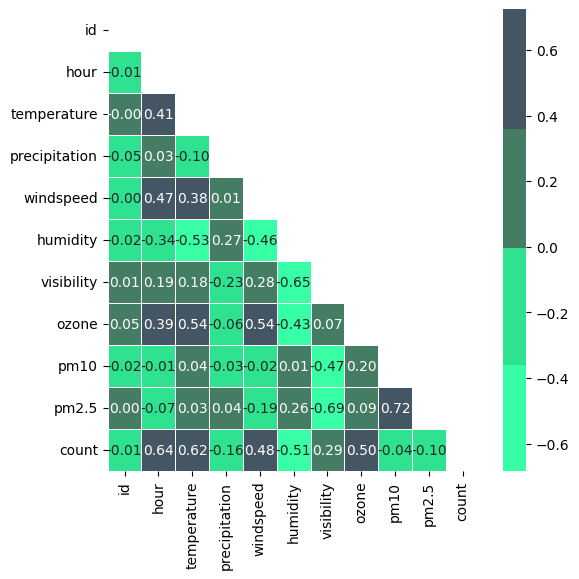

In [74]:
corr = train.corr()
print(corr['count'].sort_values(ascending = False))
plt.figure(figsize = (6,6))
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, annot = True, fmt=".2f", mask = mask, cmap = color,
           center = 0, linewidths = .5)
plt.show()

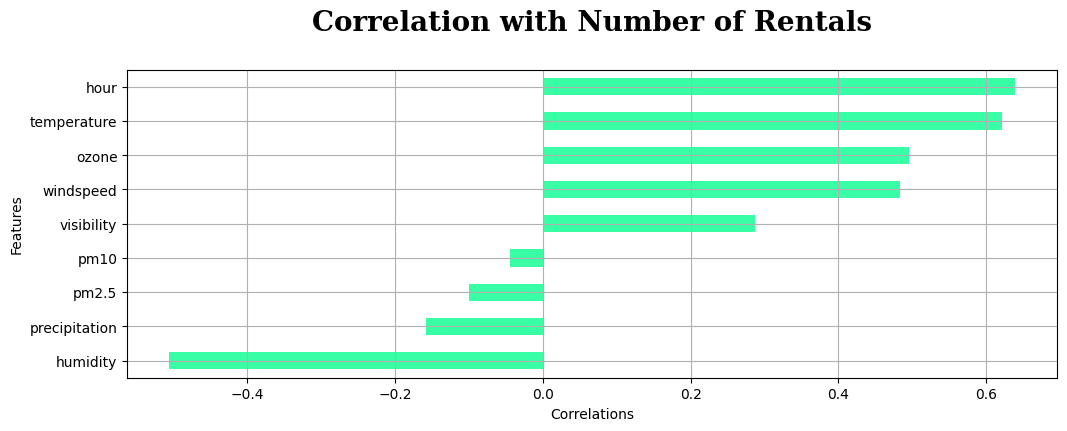

In [75]:
correlations = corr['count'].sort_values(ascending = True)
correlations = correlations[correlations != 1]
correlations = correlations[correlations.index != 'id']
correlations.plot.barh(figsize = (12,4), fontsize = 10, color = color[0], rot = 0, grid = True)
plt.title("Correlation with Number of Rentals\n", fontsize = 20, fontfamily = 'serif', fontweight = 'bold')
plt.xlabel("Correlations")
plt.ylabel("Features")
plt.show()

## 2-9. 일부 변수 특성중요도 (corr > |.4|) (Ivs with Dv)

RMSE (XGBoost): 39.25616784029992


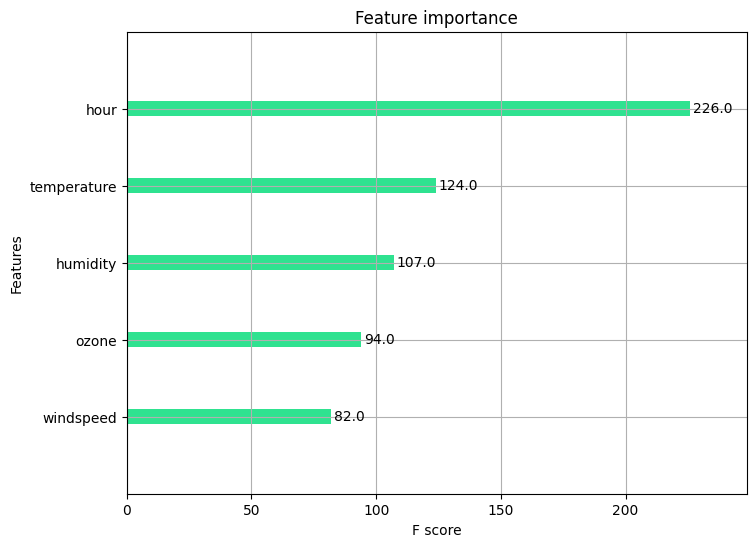

In [76]:
corr = train.corr()['count'].drop('count')
relevantF = corr[corr.abs() >= 0.4].index.tolist()

x = train[relevantF]
y = train['count']

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# XGBoost 모델 학습 및 평가
xgbr = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=2021)
xgbr.fit(X_train, y_train)
pred = xgbr.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, pred))
print(f'RMSE (XGBoost): {rmse}')

# 중요 변수 시각화
fig, ax = plt.subplots(figsize=(8, 6))
plot_importance(xgbr, ax=ax, color = color[1])
plt.show()

## 2-10. Polynomial
- 변수중요도가 높게 나온 변수 hour 과 hour_bef_temperature에 가중치 부여

In [77]:
identity = busyTrain[['id']]
X = busyTrain[busyTrain.columns.difference(['count'])]
features = X.columns.tolist()
print(features)

X = np.column_stack((X['hour'] ** 5, X['temperature'] ** 4, X))
y = busyTrain[['count']]

['busyHour', 'hour', 'humidity', 'id', 'ozone', 'pm10', 'pm2.5', 'precipitation', 'temperature', 'visibility', 'windspeed']


In [78]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 2021)

# 3. Modeling

### LinearRegression

In [79]:
pipeLR = make_pipeline(MinMaxScaler(), LinearRegression())
pipeLR.fit(X_train, y_train)
pred = pipeLR.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, pred))
print(f"RMSE of Linear Rgression : {rmse:.6f}")
results = pd.DataFrame([['Linear Regression', rmse.round(6), None]], columns = ['Model', 'RMSE', 'Best Model'])
results = results.sort_values(['RMSE'], ascending = True)
display(results)

RMSE of Linear Rgression : 44.753779


,Model,RMSE,Best Model
0,Linear Regression,44.753779,None


### Ridge

In [80]:
alphas = [0.01, 0.1, 1.0, 10, 100]
params = {'ridge__alpha': alphas}
pipeRidge = make_pipeline(MinMaxScaler(), Ridge())
gs = GridSearchCV(pipeRidge, params, cv = 5, scoring = 'neg_mean_squared_error', verbose = 0)
gs.fit(X_train, y_train)
bestParam = gs.best_params_
bestModel = gs.best_estimator_
bestScore = -gs.best_score_
print(f"Best Param of Ridge: {bestParam}")
print(f"Best RMSE of Ridge: {np.sqrt(bestScore)}")
result = pd.DataFrame([['Ridge', np.sqrt(bestScore), None]], columns = ['Model', 'RMSE', 'Best Model'])
results = results.append(result, ignore_index = True)
results = results.sort_values(['RMSE'], ascending = False)
display(results)

Best Param of Ridge: {'ridge__alpha': 1.0}
Best RMSE of Ridge: 48.10529848339259


,Model,RMSE,Best Model
1,Ridge,48.105298,None
0,Linear Regression,44.753779,None


### Lasso

In [81]:
params = {'lasso__alpha': alphas}
pipeLasso = make_pipeline(MinMaxScaler(), Lasso())
gs = GridSearchCV(pipeLasso, params, cv = 5, scoring = 'neg_mean_squared_error', verbose = 0)
gs.fit(X_train, y_train)
bestParam = gs.best_params_
bestModel = gs.best_estimator_
bestScore = -gs.best_score_
print(f"Best Param of Lasso: {bestParam}")
print(f"Best RMSE of Lasso: {np.sqrt(bestScore)}")
result = pd.DataFrame([['Lasso', np.sqrt(bestScore), None]], columns = ['Model', 'RMSE', 'Best Model'])
results = results.append(result, ignore_index = True)
results = results.sort_values(['RMSE'], ascending = False)
display(results)

Best Param of Lasso: {'lasso__alpha': 0.01}
Best RMSE of Lasso: 48.157463024010596


,Model,RMSE,Best Model
2,Lasso,48.157463,None
0,Ridge,48.105298,None
1,Linear Regression,44.753779,None


### ElasticNet

In [82]:
params = {
    'elasticnet__l1_ratio': [0.001, 0.01, 0.05, 0.1, 0.5, 1],
    'elasticnet__alpha': [0.001, 0.01, 0.05, 0.1, 1, 10]
}
pipeEN = make_pipeline(MinMaxScaler(), ElasticNet())
gs = GridSearchCV(pipeEN, params, cv = 5, scoring = 'neg_mean_squared_error', verbose = 0)
gs.fit(X_train, y_train)
bestParam = gs.best_params_
bestModel = gs.best_estimator_
bestScore = -gs.best_score_
print(f"Best Model of ElasticNet: {bestModel}")
print(f"Best Param of ElasticNet: {bestParam}")
print(f"Best RMSE of ElasticNet: {np.sqrt(bestScore)}")
result = pd.DataFrame([['ElasticNet', np.sqrt(bestScore), bestModel]], columns = ['Model', 'RMSE', 'Best Model'])
results = results.append(result, ignore_index = True)
results = results.sort_values(['RMSE'], ascending = False)
display(results)

Best Model of ElasticNet: Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('elasticnet', ElasticNet(alpha=0.001, l1_ratio=0.001))])
Best Param of ElasticNet: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.001}
Best RMSE of ElasticNet: 48.109986386735834


,Model,RMSE,Best Model
0,Lasso,48.157463,None
3,ElasticNet,48.109986,"(MinMaxScaler(), ElasticNet(alpha=0.001, l1_ra..."
1,Ridge,48.105298,None
2,Linear Regression,44.753779,None


### DecisionTreeRegressor

In [83]:
params = {
    'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
    'max_depth': range(5, 20, 1),
    'min_samples_split': range(2, 100, 10),
    'min_samples_leaf': [1, 3, 5]
}

gs = GridSearchCV(DecisionTreeRegressor(random_state=42), params, cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs = -1)
gs.fit(X_train, y_train)

bestParam = gs.best_params_
bestModel = gs.best_estimator_
bestScore = -gs.best_score_

print("DecisionTreeRegressor: \n")
print(f"Best Model: {bestModel}")
print(f"Best Param: {bestParam}")
print(f"Best RMSE: {np.sqrt(bestScore)}")
result = pd.DataFrame([['DecisionTreeRegressor', np.sqrt(bestScore), bestModel]], columns = ['Model', 'RMSE', 'Best Model'])
results = results.append(result, ignore_index = True)
results = results.sort_values(['RMSE'], ascending = False)
display(results)

DecisionTreeRegressor: 

Best Model: DecisionTreeRegressor(max_depth=6, min_impurity_decrease=0.0001,
                      min_samples_leaf=3, min_samples_split=32,
                      random_state=42)
Best Param: {'max_depth': 6, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 3, 'min_samples_split': 32}
Best RMSE: 45.59822168908214


,Model,RMSE,Best Model
0,Lasso,48.157463,None
1,ElasticNet,48.109986,"(MinMaxScaler(), ElasticNet(alpha=0.001, l1_ra..."
2,Ridge,48.105298,None
4,DecisionTreeRegressor,45.598222,"DecisionTreeRegressor(max_depth=6, min_impurit..."
3,Linear Regression,44.753779,None


### RandomForestRegressor

In [84]:
params = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 10, 12],
    'max_features': [5, 6, 8],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [8, 16, 20]
}

gs = GridSearchCV(RandomForestRegressor(random_state=42), params, cv=2, scoring='neg_mean_squared_error', verbose=0, n_jobs = -1)
gs.fit(X_train, y_train)

bestParam = gs.best_params_
bestModel = gs.best_estimator_
bestScore = -gs.best_score_

print("RandomForestRegressor: \n")
print(f"Best Model: {bestModel}")
print(f"Best Param: {bestParam}")
print(f"Best RMSE: {np.sqrt(bestScore)}")

result = pd.DataFrame([['RandomForestRegressor', np.sqrt(bestScore), bestModel]], columns = ['Model', 'RMSE', 'Best Model'])
results = results.append(result, ignore_index = True)
results = results.sort_values(['RMSE'], ascending = False)
display(results)

/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

RandomForestRegressor: 

Best Model: RandomForestRegressor(max_depth=12, max_features=6, min_samples_split=8,
                      random_state=42)
Best Param: {'max_depth': 12, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100}
Best RMSE: 40.98574302428173


,Model,RMSE,Best Model
0,Lasso,48.157463,None
1,ElasticNet,48.109986,"(MinMaxScaler(), ElasticNet(alpha=0.001, l1_ra..."
2,Ridge,48.105298,None
3,DecisionTreeRegressor,45.598222,"DecisionTreeRegressor(max_depth=6, min_impurit..."
4,Linear Regression,44.753779,None
5,RandomForestRegressor,40.985743,"(DecisionTreeRegressor(max_depth=12, max_featu..."


### XGBRegressor

In [85]:
# xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective='reg:squarederror', random_state=2021)

gs = GridSearchCV(XGBRegressor(random_state=42), params, cv=2, scoring='neg_mean_squared_error', n_jobs = -1)
gs.fit(X_train, y_train)

bestParam = gs.best_params_
bestModel = gs.best_estimator_
bestScore = -gs.best_score_

print("XGBRegressor: \n")
print(f"Best Model: {bestModel}")
print(f"Best Param: {bestParam}")
print(f"Best RMSE: {np.sqrt(bestScore)}")


result = pd.DataFrame([['XGBRegressor', np.sqrt(bestScore), bestModel]], columns = ['Model', 'RMSE', 'Best Model'])
results = results.append(result, ignore_index = True)
results = results.sort_values(['RMSE'], ascending = False)
display(results)

[18:00:35] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

XGBRegressor: 

Best Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_features=5, max_leaves=None,
             min_child_weight=None, min_samples_leaf=1, min_samples_split=8,
             missing=nan, monotone_constraints=None, n_estimators=200,
             n_jobs=None, ...)
Best 

,Model,RMSE,Best Model
0,Lasso,48.157463,None
1,ElasticNet,48.109986,"(MinMaxScaler(), ElasticNet(alpha=0.001, l1_ra..."
2,Ridge,48.105298,None
3,DecisionTreeRegressor,45.598222,"DecisionTreeRegressor(max_depth=6, min_impurit..."
4,Linear Regression,44.753779,None
6,XGBRegressor,41.825123,"XGBRegressor(base_score=None, booster=None, ca..."
5,RandomForestRegressor,40.985743,"(DecisionTreeRegressor(max_depth=12, max_featu..."


### LGBMRegressor

In [86]:
params = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [20, 50, 100],
    'subsample': [0.6, 0.8, 1.0]
}

gs = GridSearchCV(LGBMRegressor(random_state=42), params, cv=2, scoring='neg_mean_squared_error', n_jobs = -1)
gs.fit(X_train, y_train)

bestParam = gs.best_params_
bestModel = gs.best_estimator_
bestScore = -gs.best_score_

print("LGBMRegressor: \n")
print(f"Best Model: {bestModel}")
print(f"Best Param: {bestParam}")
print(f"Best RMSE: {np.sqrt(bestScore)}")

result = pd.DataFrame([['LGBMRegressor', np.sqrt(bestScore), bestModel]], columns = ['Model', 'RMSE', 'Best Model'])
results = results.append(result, ignore_index = True)
results = results.sort_values(['RMSE'], ascending = False)
display(results)

/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

LGBMRegressor: 

Best Model: LGBMRegressor(learning_rate=0.01, n_estimators=500, random_state=42,
              subsample=0.6)
Best Param: {'learning_rate': 0.01, 'min_child_samples': 20, 'n_estimators': 500, 'num_leaves': 31, 'subsample': 0.6}
Best RMSE: 42.669151275663914


,Model,RMSE,Best Model
0,Lasso,48.157463,None
1,ElasticNet,48.109986,"(MinMaxScaler(), ElasticNet(alpha=0.001, l1_ra..."
2,Ridge,48.105298,None
3,DecisionTreeRegressor,45.598222,"DecisionTreeRegressor(max_depth=6, min_impurit..."
4,Linear Regression,44.753779,None
7,LGBMRegressor,42.669151,"LGBMRegressor(learning_rate=0.01, n_estimators..."
5,XGBRegressor,41.825123,"XGBRegressor(base_score=None, booster=None, ca..."
6,RandomForestRegressor,40.985743,"(DecisionTreeRegressor(max_depth=12, max_featu..."


### ExtraTreesRegressor

In [87]:
params = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 10, 12],
    'max_features': [5, 6, 8],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [8, 16, 20]
}

gs = GridSearchCV(ExtraTreesRegressor(random_state=42), params, cv=2, scoring='neg_mean_squared_error', n_jobs = -1)
gs.fit(X_train, y_train)

bestParam = gs.best_params_
bestModel = gs.best_estimator_
bestScore = -gs.best_score_

print("ExtraTreesRegressor: \n")
print(f"Best Model: {bestModel}")
print(f"Best Param: {bestParam}")
print(f"Best RMSE: {np.sqrt(bestScore)}")

result = pd.DataFrame([['ExtraTreesRegressor', np.sqrt(bestScore), bestModel]], columns = ['Model', 'RMSE', 'Best Model'])
results = results.append(result, ignore_index = True)
results = results.sort_values(['RMSE'], ascending = False)
display(results)

/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

ExtraTreesRegressor: 

Best Model: ExtraTreesRegressor(max_depth=12, max_features=6, min_samples_split=8,
                    n_estimators=200, random_state=42)
Best Param: {'max_depth': 12, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 200}
Best RMSE: 39.659103616357406


,Model,RMSE,Best Model
0,Lasso,48.157463,None
1,ElasticNet,48.109986,"(MinMaxScaler(), ElasticNet(alpha=0.001, l1_ra..."
2,Ridge,48.105298,None
3,DecisionTreeRegressor,45.598222,"DecisionTreeRegressor(max_depth=6, min_impurit..."
4,Linear Regression,44.753779,None
5,LGBMRegressor,42.669151,"LGBMRegressor(learning_rate=0.01, n_estimators..."
6,XGBRegressor,41.825123,"XGBRegressor(base_score=None, booster=None, ca..."
7,RandomForestRegressor,40.985743,"(DecisionTreeRegressor(max_depth=12, max_featu..."
8,ExtraTreesRegressor,39.659104,"(ExtraTreeRegressor(max_depth=12, max_features..."


### AdaBoostRegressor

In [88]:
params = {'n_estimators':[50, 10],
         'learning_rate': [0.01, 0.05, 0.1, 0.5],
         'loss': ['linear', 'square', 'exponential']}

gs = GridSearchCV(AdaBoostRegressor(random_state=42), params, cv=2, scoring='neg_mean_squared_error', n_jobs = -1)
gs.fit(X_train, y_train)

bestParam = gs.best_params_
bestModel = gs.best_estimator_
bestScore = -gs.best_score_

print("AdaBoostRegressor: \n")
print(f"Best Model: {bestModel}")
print(f"Best Param: {bestParam}")
print(f"Best RMSE: {np.sqrt(bestScore)}")

result = pd.DataFrame([['AdaBoostRegressor', np.sqrt(bestScore), bestModel]], columns = ['Model', 'RMSE', 'Best Model'])
results = results.append(result, ignore_index = True)
results = results.sort_values(['RMSE'], ascending = False)
display(results)

/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/minkim/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

AdaBoostRegressor: 

Best Model: AdaBoostRegressor(learning_rate=0.1, loss='exponential', random_state=42)
Best Param: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}
Best RMSE: 46.280316185068244


,Model,RMSE,Best Model
0,Lasso,48.157463,None
1,ElasticNet,48.109986,"(MinMaxScaler(), ElasticNet(alpha=0.001, l1_ra..."
2,Ridge,48.105298,None
9,AdaBoostRegressor,46.280316,"(DecisionTreeRegressor(max_depth=3, random_sta..."
3,DecisionTreeRegressor,45.598222,"DecisionTreeRegressor(max_depth=6, min_impurit..."
4,Linear Regression,44.753779,None
5,LGBMRegressor,42.669151,"LGBMRegressor(learning_rate=0.01, n_estimators..."
6,XGBRegressor,41.825123,"XGBRegressor(base_score=None, booster=None, ca..."
7,RandomForestRegressor,40.985743,"(DecisionTreeRegressor(max_depth=12, max_featu..."
8,ExtraTreesRegressor,39.659104,"(ExtraTreeRegressor(max_depth=12, max_features..."


### 모델링 결과

In [89]:
results = results.sort_values(['RMSE'], ascending = True)
display(results)

,Model,RMSE,Best Model
8,ExtraTreesRegressor,39.659104,"(ExtraTreeRegressor(max_depth=12, max_features..."
7,RandomForestRegressor,40.985743,"(DecisionTreeRegressor(max_depth=12, max_featu..."
6,XGBRegressor,41.825123,"XGBRegressor(base_score=None, booster=None, ca..."
5,LGBMRegressor,42.669151,"LGBMRegressor(learning_rate=0.01, n_estimators..."
4,Linear Regression,44.753779,None
3,DecisionTreeRegressor,45.598222,"DecisionTreeRegressor(max_depth=6, min_impurit..."
9,AdaBoostRegressor,46.280316,"(DecisionTreeRegressor(max_depth=3, random_sta..."
2,Ridge,48.105298,None
1,ElasticNet,48.109986,"(MinMaxScaler(), ElasticNet(alpha=0.001, l1_ra..."
0,Lasso,48.157463,None


### Pycaret

In [90]:
# pycaretDF = train.copy()
# from pycaret.regression import setup, compare_models, pull
# reg = setup(pycaretDF, target = 'count', train_size = 0.8)

## 하이퍼파라미터 튜닝

In [91]:
results['Best Model'][8]

ExtraTreesRegressor(max_depth=12, max_features=6, min_samples_split=8,
                    n_estimators=200, random_state=42)

In [92]:
def objective_extratree(trial):
    params_et = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=10),
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 3),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 4, 5, 6]),
        "warm_start": trial.suggest_categorical("warm_start", [True, False]),
        "random_state": 2021
    }
    
    X = busyTrain[busyTrain.columns.difference(['count'])]
    y = busyTrain['count']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=2021)
    
    model = ExtraTreesRegressor(**params_et)
    model.fit(X_train, y_train)
    
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    
    return rmse

# Optuna 스터디 설정
sampler = TPESampler(seed=2021)
study = optuna.create_study(
    study_name="et_optimizer",
    direction="minimize",
    sampler=sampler
)

# 최적화 실행
study.optimize(objective_extratree, n_trials=30)

# 최적 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-10 18:01:06,724] A new study created in memory with name: et_optimizer
[I 2024-06-10 18:01:07,773] Trial 0 finished with value: 37.674041118481654 and parameters: {'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'warm_start': True}. Best is trial 0 with value: 37.674041118481654.
[I 2024-06-10 18:01:07,991] Trial 1 finished with value: 37.642548426131455 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 4, 'warm_start': True}. Best is trial 1 with value: 37.642548426131455.
[I 2024-06-10 18:01:08,509] Trial 2 finished with value: 50.020693703229384 and parameters: {'n_estimators': 610, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2', 'warm_start': False}. Best is trial 1 with value: 37.642548426131455.
[I 2024-06-10 18:01:08,896] Trial 3 finished with value: 37.6062417053447 and parameters: {'n_estimators': 280

Best trial:
  Value: 35.877419337304175
  Params: 
    n_estimators: 320
    max_depth: 15
    min_samples_split: 3
    min_samples_leaf: 1
    max_features: 6
    warm_start: True


# 최종

In [93]:
test.head()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [97]:
X = busyTrain[busyTrain.columns.difference(['count', 'hour_bef_visibility'])]
features = X.columns.tolist()
X = np.column_stack((X['hour'] ** 5, X['temperature']**4, X))
y = busyTrain['count']

test2 = test[test.columns.difference(['count', 'hour_bef_visibility'])].copy()
test2 = busyHour(test2, 'hour')
test2 = test2[features]
X_test = np.column_stack((test2['hour'] ** 5, test2['temperature']**4, test2))
X_test = IterativeImputer(random_state = 2021).fit_transform(X_test)

bestREG = ExtraTreesRegressor(n_estimators = 320, max_depth = 15, min_samples_split = 3, min_samples_leaf = 1, max_features = 6, warm_start=True)
bestREG.fit(X,y)
pred = bestREG.predict(X_test)

submission['count'] = pred
submission.to_csv('final2.csv', index=False)
print(f"file saved.")

file saved.


In [101]:
X = busyTrain[busyTrain.columns.difference(['count', 'visibility'])]
features = X.columns.tolist()
X = np.column_stack((X['hour'] ** 5, X['temperature']**4, X))
y = busyTrain['count']

test2 = test[test.columns.difference(['count', 'hour_bef_visibility'])].copy()
test2 = busyHour(test2, 'hour')
test2 = test2[features]
X_test = np.column_stack((test2['hour'] ** 5, test2['temperature']**4, test2))
X_test = IterativeImputer(random_state = 2021).fit_transform(X_test)

# bestREG = ExtraTreesRegressor(n_estimators = 430, max_depth = 16, min_samples_split = 4, min_samples_leaf = 1, max_features = 'auto', warm_start=True)
bestREG = ExtraTreesRegressor(n_estimators = 320, max_depth = 15, min_samples_split = 3, min_samples_leaf = 1, max_features = 6, warm_start=True)

bestREG.fit(X,y)
pred = bestREG.predict(X_test)

submission['count'] = pred
submission.to_csv('final1.csv', index=False)
print(f"file saved.")

file saved.
